<a href="https://colab.research.google.com/github/Yaakov-Sternberg/AAI-510-Final-Project-Group7/blob/main/Version%20including%20initial%20Transformers%20try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Temp

In [ ]:
!pip install -q --upgrade gensim scikit-learn transformers datasets accelerate torch
import os
os.kill(os.getpid(), 9)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 457.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
# Install & Import

# library imports
import os
import re
import io
import csv
import sys
import nltk
import time
import joblib
import string
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
import gensim.downloader as api

from pathlib import Path
from tqdm.auto import tqdm
from google.colab import files, drive
from IPython.display import display, HTML
from transformers import AutoTokenizer, AutoModel

# Scikit-learn imports
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    matthews_corrcoef,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    f1_score,
    precision_score,
    recall_score,
    log_loss,
    average_precision_score
)

# NLTK imports
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize

# --- Configure Environment ---
# Download NLTK assets
nltk.download("punkt", quiet=True)
nltk.download("wordnet", quiet=True)
nltk.download("stopwords", quiet=True)
nltk.download('punkt_tab', quiet=True)


# tqdm for progress monitoring
tqdm.pandas()

drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
# Path to file in Google Drive
file_path = '/content/drive/My Drive/spam_Emails_data.csv'

# Load CSV file into a pandas DataFrame (DF)
df = pd.read_csv(file_path)

print(df.head())

  label                                               text
0  Spam  viiiiiiagraaaa\nonly for the ones that want to...
1   Ham  got ice thought look az original message ice o...
2  Spam  yo ur wom an ne eds an escapenumber in ch ma n...
3  Spam  start increasing your odds of success & live s...
4   Ham  author jra date escapenumber escapenumber esca...


# Preprocessing

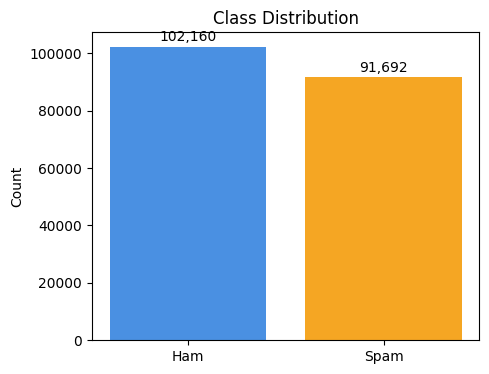

In [14]:
# Convert labels to 0s and 1s
df['label'] = df['label'].map({'Ham': 0, 'Spam': 1})

# Visualize Class Distribution
plt.figure(figsize=(5, 4))
counts = df["label"].value_counts().rename({0:"Ham", 1:"Spam"})
plt.bar(counts.index, counts.values, color=["#4A90E2","#F5A623"])
plt.title("Class Distribution")
plt.ylabel("Count")
# Add text labels on bars
for i, v in enumerate(counts.values):
    plt.text(i, v + 0.02 * v, f"{v:,}", ha="center")
plt.show()

In [15]:
# Pre-compile regex patterns (more efficient/neater)
PATTERNS = {
    "url": re.compile(r"http[s]?://\S+"),
    "email": re.compile(r"\S+@\S+"),
    "non_alnum": re.compile(r"[^a-zA-Z0-9\s]"),
}

# Initialize NLTK components
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    """Applies regex-based cleaning."""
    text = PATTERNS["url"].sub(" ", text)
    text = PATTERNS["email"].sub(" ", text)
    text = PATTERNS["non_alnum"].sub(" ", text)
    return text.strip()

def tokenize_and_normalize(text):
    """Tokenizes, lowercases, removes stopwords, and lemmatizes."""
    tokens = word_tokenize(text.lower())
    return [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and len(t) > 1]

def preprocess(text):
    """Full preprocessing pipeline."""
    if not isinstance(text, str):
        return ""
    return " ".join(tokenize_and_normalize(clean_text(text)))

df["processed_text"] = df["text"].progress_apply(preprocess)

# Stratified Sample & Data-Driven Vocab Creation
SAMPLE_SIZE = 20_000
df_sample, _ = train_test_split(df, train_size=SAMPLE_SIZE, stratify=df["label"], random_state=1234)
sample_text = df.loc[df_sample.index, "processed_text"]
sample_labels = df.loc[df_sample.index, "label"]

print(f"Sample size for intensive steps = {len(df_sample)}")
print(f"Spam ratio in sample ≈ {df_sample['label'].mean()}")

  0%|          | 0/193852 [00:00<?, ?it/s]

Sample size for intensive steps = 20000
Spam ratio in sample ≈ 0.473


Conclusion: Dataset is well balanced - no need for weighting or sampeling.

# Feature Engineering

Spam Vocabulary based on TF-IDF scores

In [16]:
# Instead of using a hard-coded list, I derive the most characteristic spam words
# from the data itself using TF-IDF scores to make the feature more robust.
tfidf_vectorizer_vocab = TfidfVectorizer(max_features=5000, stop_words='english', min_df=5)
tfidf_matrix_vocab = tfidf_vectorizer_vocab.fit_transform(sample_text)
feature_names_vocab = np.array(tfidf_vectorizer_vocab.get_feature_names_out())

spam_mask_vocab = sample_labels == 1
spam_tfidf_mean = np.asarray(tfidf_matrix_vocab[spam_mask_vocab.values].mean(axis=0)).ravel()

# Get top 30 words with the highest average TF-IDF score in spam emails
top_spam_indices = spam_tfidf_mean.argsort()[::-1][:30]
DATA_DRIVEN_SPAM_VOCAB = set(feature_names_vocab[top_spam_indices])
print(f"Top spam keywords found: {list(DATA_DRIVEN_SPAM_VOCAB)[:10]}...") # Print a sample


Top spam keywords found: ['escapenumber', 'email', 'info', 'http', 'site', 'www', 'adobe', 'bescapenumber', 'company', 'watch']...


Vectorized FE

In [17]:
# This vectorized approach is faster than using .progress_apply() row-by-row.
# Add other patterns needed for feature engineering
PATTERNS.update({
    "hyperlink": re.compile(r"(http|www|\.com)"),
    "digit": re.compile(r"\d"),
    "upper_word": re.compile(r"\b[A-Z]{2,}\b"),
    "phone": re.compile(r"\b(?:\d{3}[-.\s]?)?\d{3}[-.\s]?\d{4}\b"),
    "repeat_char": re.compile(r"(.)\1{2,}"),
})

# Ensure 'text' & 'processed_text' are strings to avoid errors
raw_text = df["text"].astype(str)
processed_tokens = df["processed_text"].str.split().fillna("").apply(list)

# Create a features DataFrame to hold the new columns
features = pd.DataFrame(index=df.index)

# Basic Counts
features["feat_char_count"] = raw_text.str.len()
features["feat_word_count"] = processed_tokens.str.len()
features["feat_sentence_count"] = raw_text.apply(lambda x: len(sent_tokenize(x))).clip(lower=1)
features["feat_avg_word_len"] = raw_text.str.split().str.join('').str.len() / features["feat_word_count"].clip(lower=1)
features["feat_paragraph_count"] = raw_text.str.count(r'\n\n') + 1

# Spam Indicators
features["feat_hyperlink_count"] = raw_text.str.lower().str.count(PATTERNS["hyperlink"])
features["feat_exclamation_count"] = raw_text.str.count("!")
features["feat_question_count"] = raw_text.str.count(r"\?")
features["feat_digit_count"] = raw_text.str.count(PATTERNS["digit"])
features["feat_uppercase_word_count"] = raw_text.str.count(PATTERNS["upper_word"])
features["feat_special_char_count"] = raw_text.str.count(fr"[{re.escape(string.punctuation)}]")
features["feat_currency_symbol_count"] = raw_text.str.count(r"[$£€]")
features["feat_phone_pattern_count"] = raw_text.str.count(PATTERNS["phone"])
features["feat_spam_word_count"] = processed_tokens.apply(lambda tokens: sum(1 for word in tokens if word in DATA_DRIVEN_SPAM_VOCAB))

# Communication Style
features["feat_uppercase_char_ratio"] = raw_text.str.count(r"[A-Z]") / features["feat_char_count"]
features["feat_repeated_char_count"] = raw_text.str.count(PATTERNS["repeat_char"])
features["feat_word_diversity"] = processed_tokens.apply(lambda x: len(set(x))) / features["feat_word_count"]

# Fill NaNs that might result from division by zero (e.g., in empty emails)
features = features.fillna(0)

# Join the new features with the original DataFrame
df = df.join(features)


Visual Exploration by Label

<ipython-input-18-3829628245>:17: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[i].set_yscale('log')
<ipython-input-18-3829628245>:17: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[i].set_yscale('log')


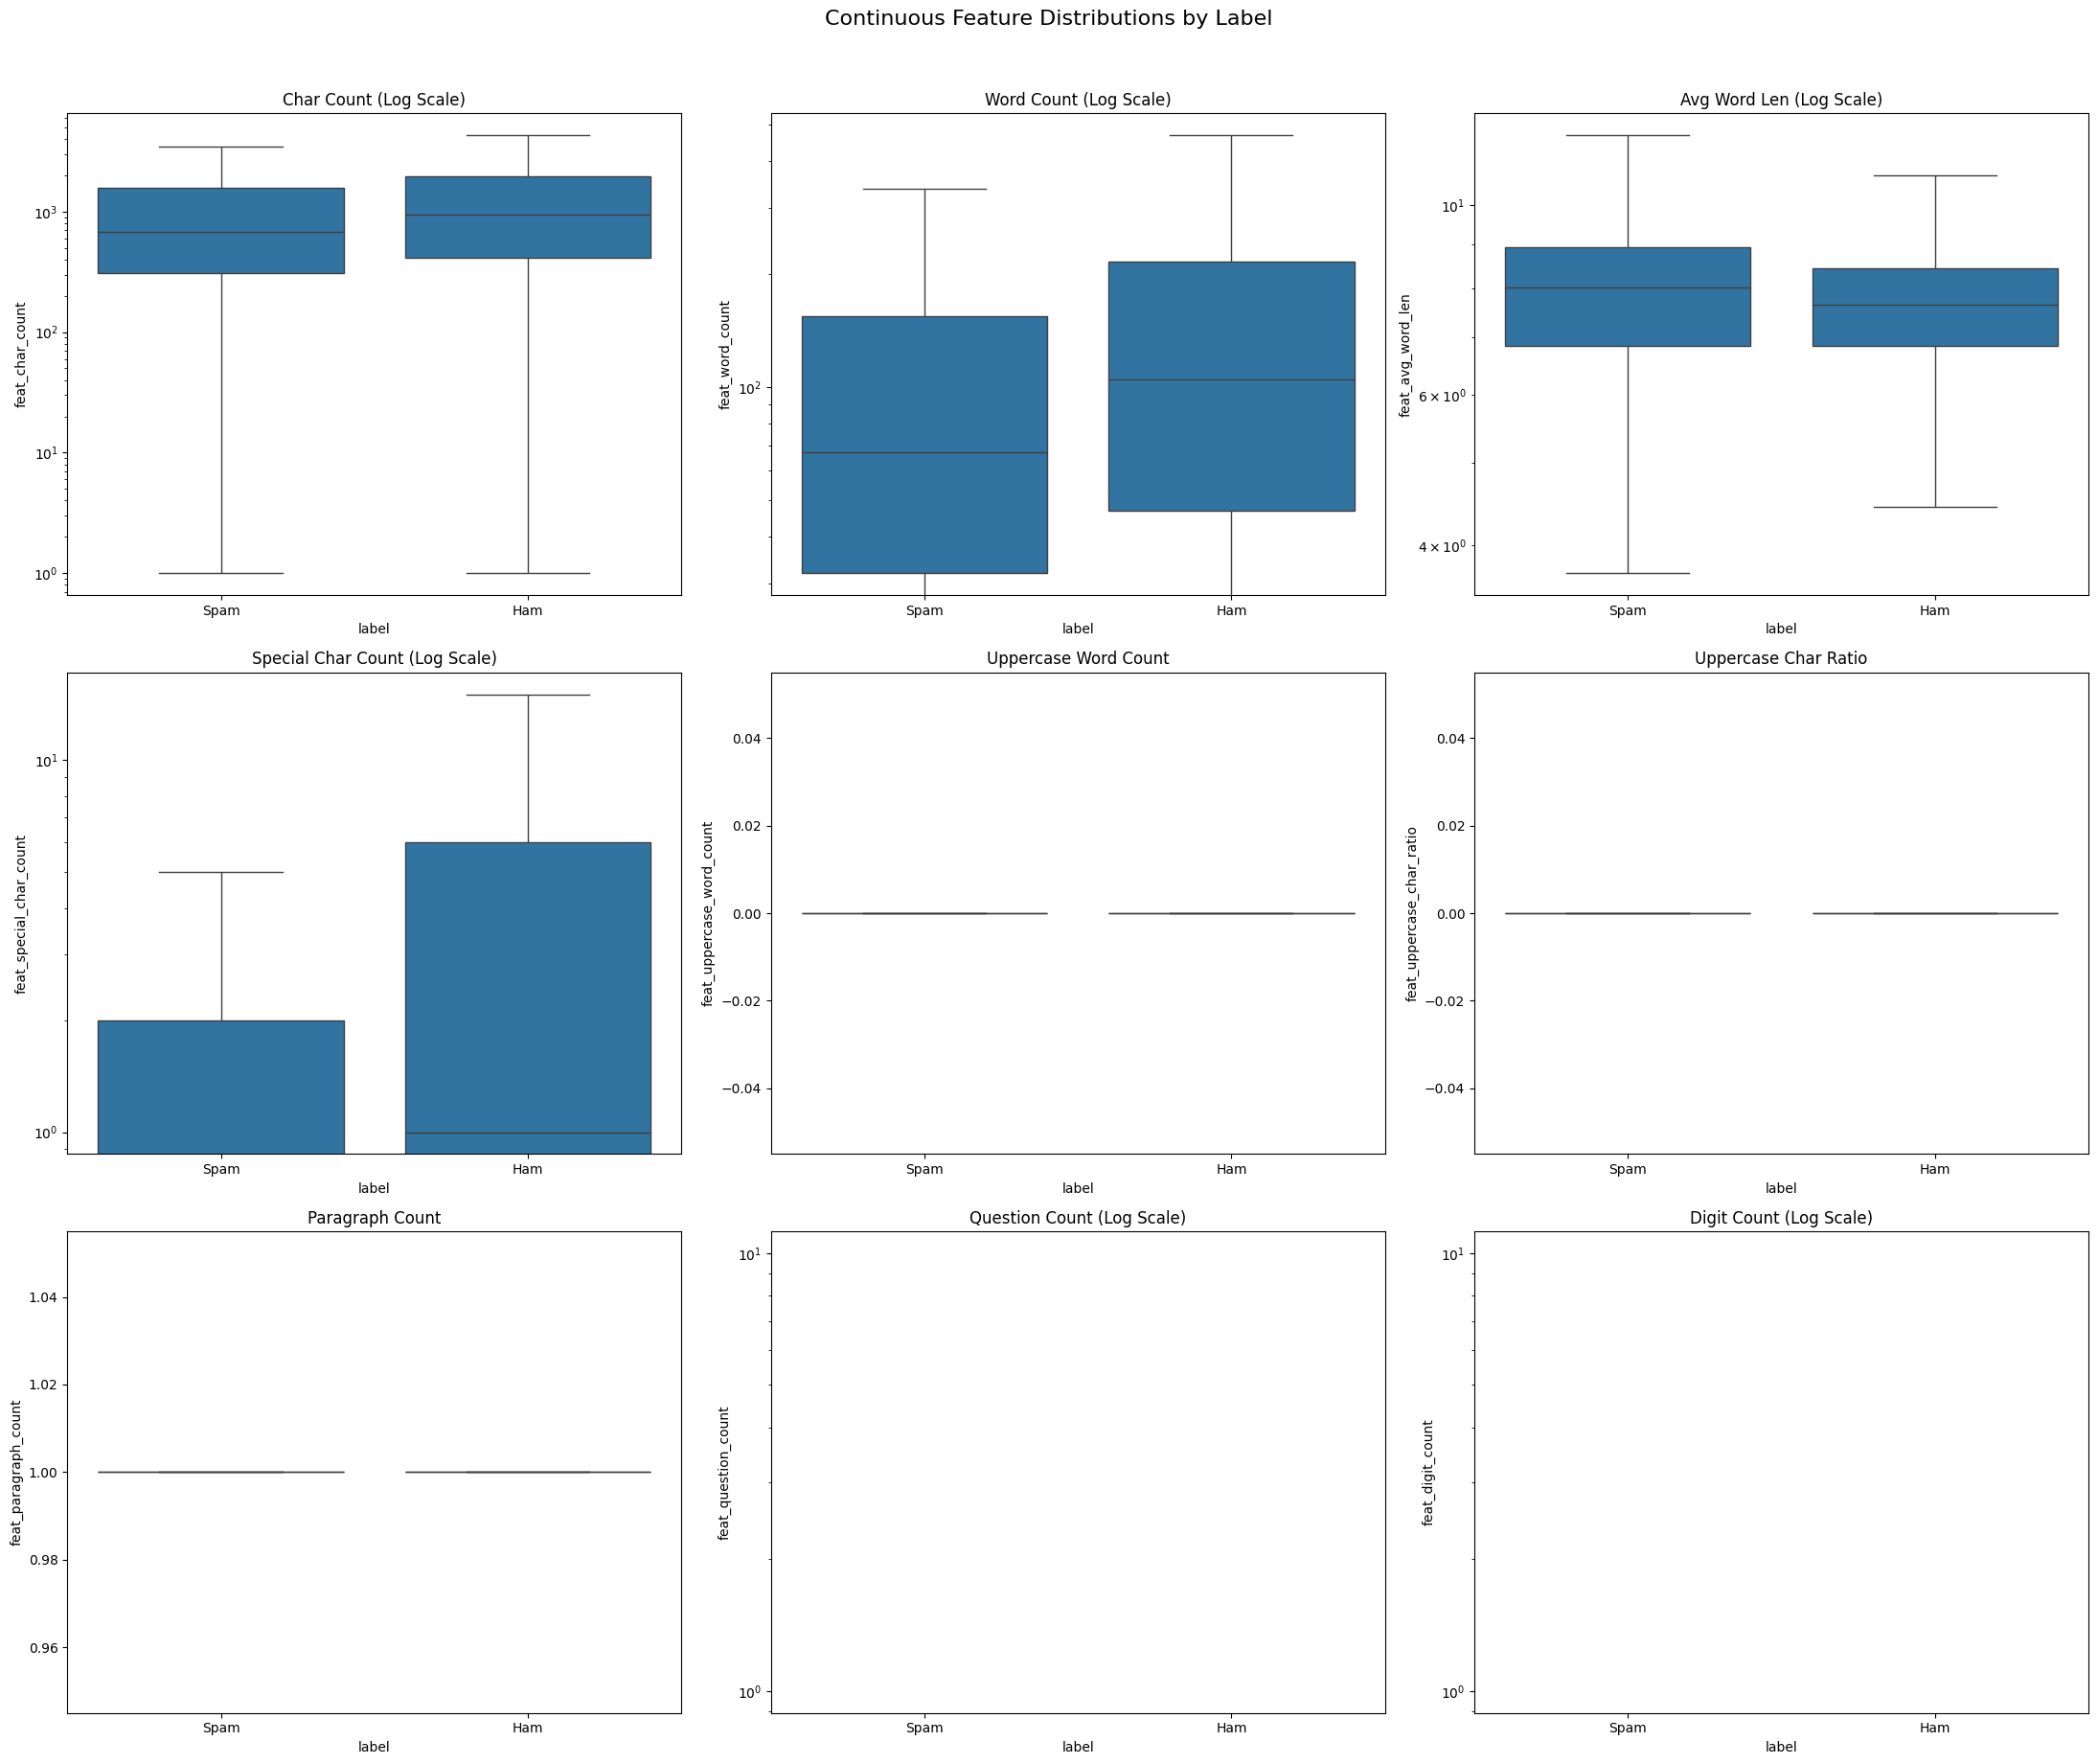

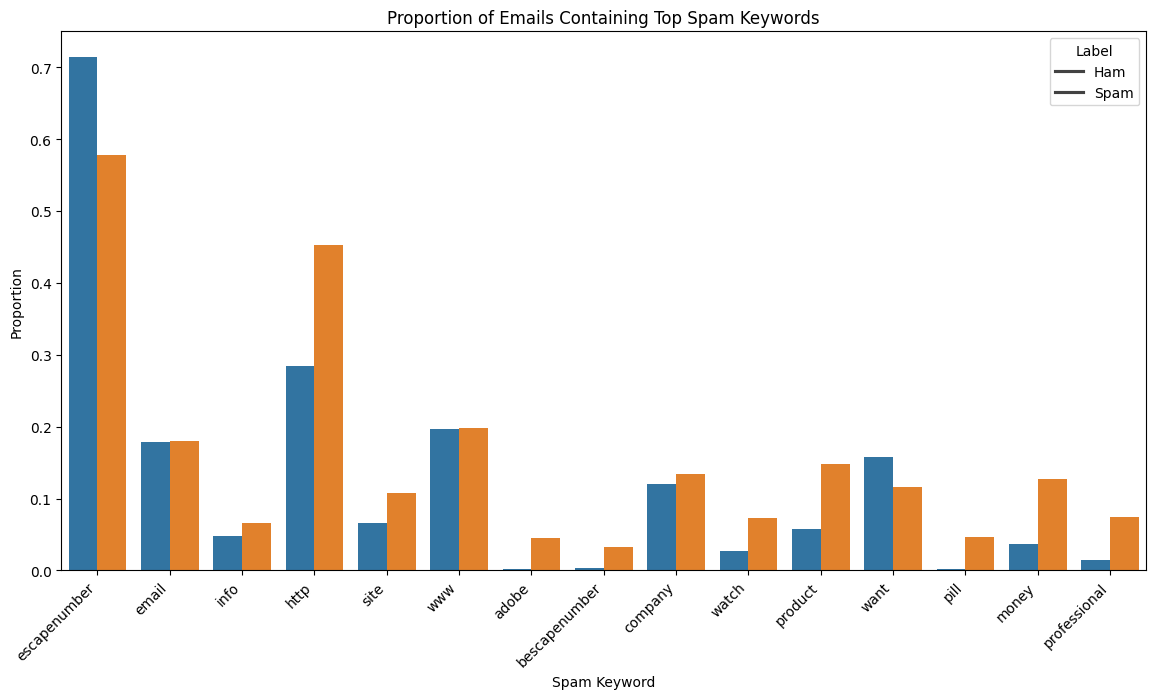

In [18]:
# Boxplots for Continuous Features
continuous_features = [
    'feat_char_count', 'feat_word_count', 'feat_avg_word_len',
    'feat_special_char_count', 'feat_uppercase_word_count', 'feat_uppercase_char_ratio',
    'feat_paragraph_count', 'feat_question_count', 'feat_digit_count'
]
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(22, 18))
fig.suptitle('Continuous Feature Distributions by Label', y=1.02, fontsize=16)
axes = axes.flatten()

for i, feature in enumerate(continuous_features):
    sns.boxplot(data=df.assign(label=df['label'].map({0: 'Ham', 1: 'Spam'})),
            x='label', y=feature, ax=axes[i], showfliers=False)
    axes[i].set_title(feature.replace("feat_", "").replace("_", " ").title())

    if df[feature].skew() > 3:
        axes[i].set_yscale('log')
        axes[i].set_title(f'{axes[i].get_title()} (Log Scale)')

plt.tight_layout()
plt.show()

# Spam Keyword Presence Bar Chart
# Checks for the presence of a subset of our data-driven vocab
plot_vocab = list(DATA_DRIVEN_SPAM_VOCAB)[:15]
keyword_cols = [f"feat_has_{w}" for w in plot_vocab]
for word in plot_vocab:
    df[f"feat_has_{word}"] = df["processed_text"].str.contains(fr"\b{word}\b", regex=True).astype(int)

prop_df = df.groupby("label")[keyword_cols].mean().reset_index()
prop_df_melted = prop_df.melt(id_vars="label", var_name="keyword", value_name="proportion")
prop_df_melted["keyword"] = prop_df_melted["keyword"].str.replace("feat_has_", "", regex=False)

plt.figure(figsize=(14, 7))
sns.barplot(x="keyword", y="proportion", hue="label", data=prop_df_melted)
plt.title("Proportion of Emails Containing Top Spam Keywords")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Proportion")
plt.xlabel("Spam Keyword")
plt.legend(title='Label', labels=['Ham', 'Spam'])
plt.show()

Conclusions:

We've found several strong predictors (eg. Special Char Count, Digit Count) and some surprisingly weak ones (Uppercase Word Count).

The TF-IDF shows some promissing indicators that will be very useful for a classification model (eg. 'http', 'net', 'escapenumber', 'adobe', 'watch', 'info', 'best')

N-gram Frequency Analysis

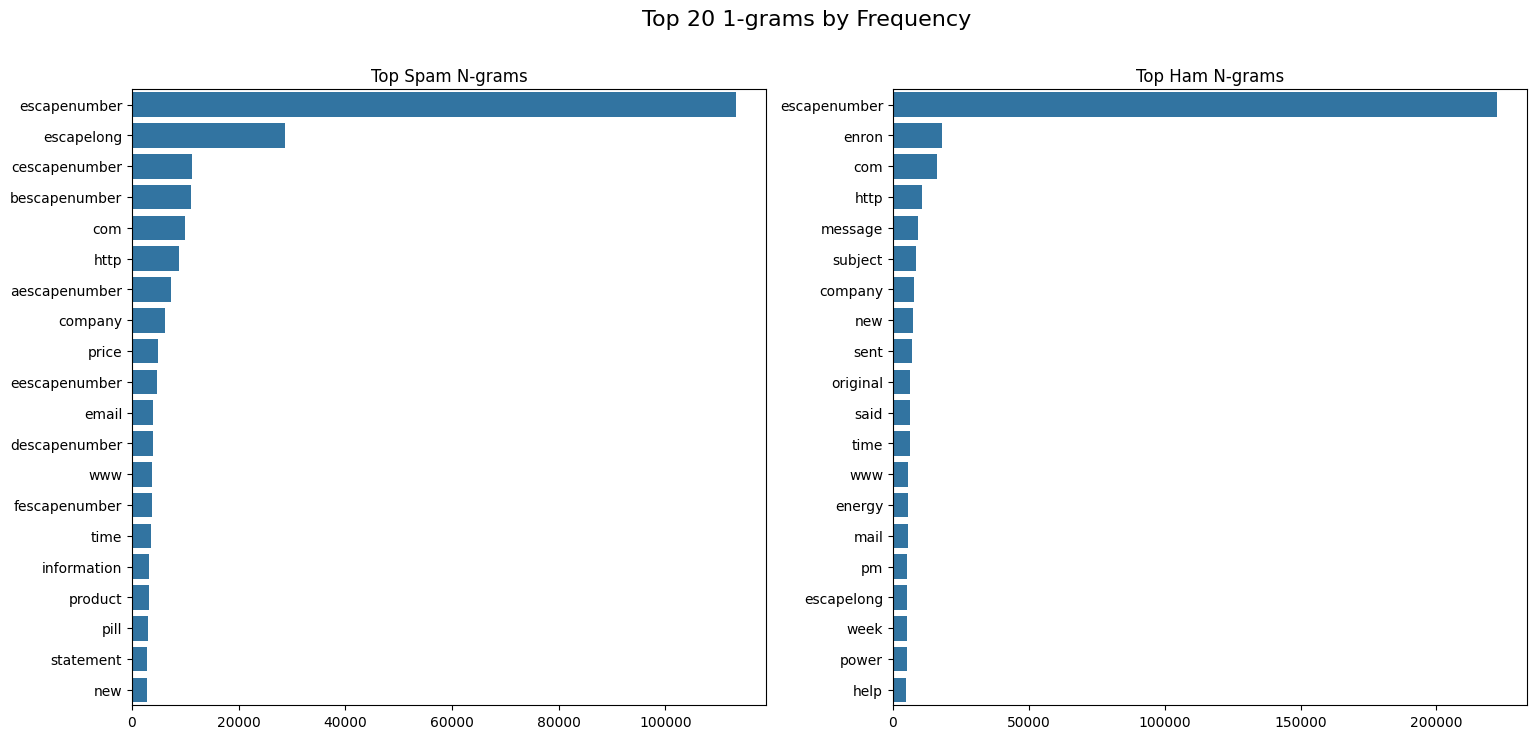

In [20]:
n = 20
ngram_range = (1, 1)

# Vectorize the text
vect = CountVectorizer(ngram_range=ngram_range, stop_words="english", min_df=5)
X = vect.fit_transform(sample_text)
vocab = np.array(vect.get_feature_names_out())

# Prepare data for plotting by converting boolean Series to np arrays using .values
masks = ((sample_labels == 1).values, (sample_labels == 0).values) # Spam, Ham
titles = ("Top Spam N-grams", "Top Ham N-grams")

# Create & display plots
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle(f"Top {n} {ngram_range[0]}-grams by Frequency", fontsize=16)

for i, (mask, title) in enumerate(zip(masks, titles)):
    counts = np.asarray(X[mask].sum(axis=0)).ravel()
    top_indices = counts.argsort()[::-1][:n]
    sns.barplot(x=counts[top_indices], y=vocab[top_indices], ax=axes[i])
    axes[i].set_title(title)

plt.show()

Distinctive Term Analysis using TF-IDF

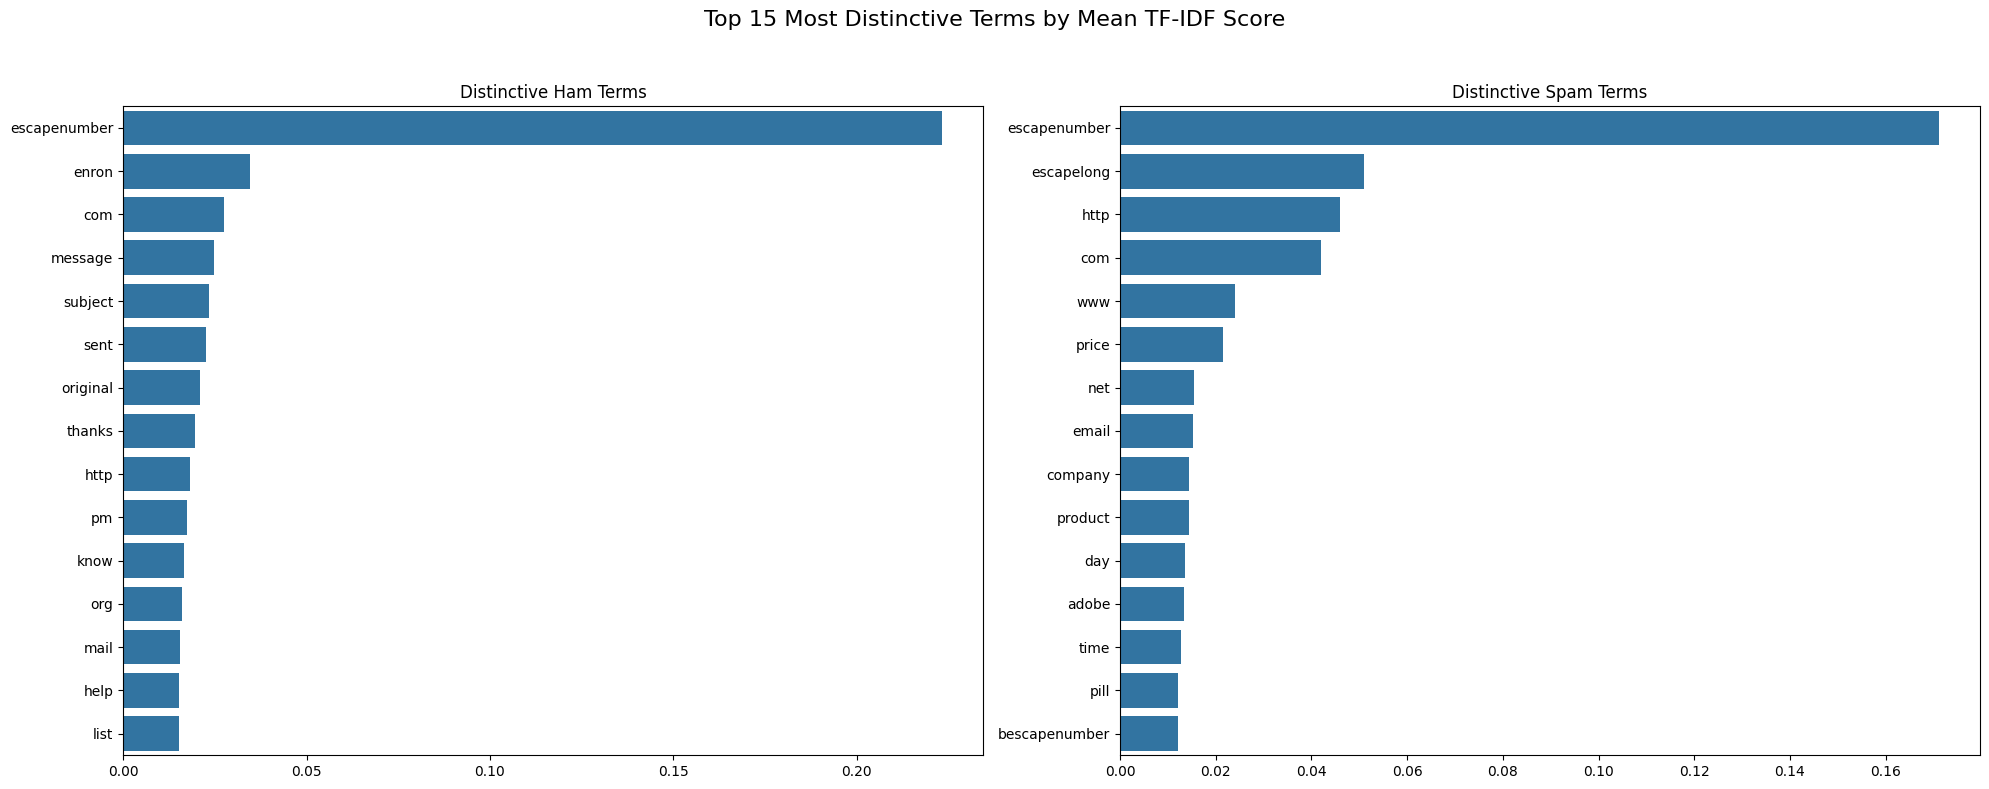

In [10]:
# Re-use the TF-IDF matrix & vectorizer from the vocab creation step
tfidf_matrix = tfidf_matrix_vocab
tfidf_vectorizer = tfidf_vectorizer_vocab
feature_names = feature_names_vocab
spam_mask = spam_mask_vocab.values

ham_tfidf_mean = np.asarray(tfidf_matrix[~spam_mask].mean(axis=0)).ravel()

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle("Top 15 Most Distinctive Terms by Mean TF-IDF Score", fontsize=16)
for i, (title, means) in enumerate([("Ham", ham_tfidf_mean), ("Spam", spam_tfidf_mean)]):
    top_indices = means.argsort()[::-1][:15]
    sns.barplot(x=means[top_indices], y=feature_names[top_indices], ax=axes[i])
    axes[i].set_title(f"Distinctive {title} Terms")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Dimensionality Reduction with t-SNE

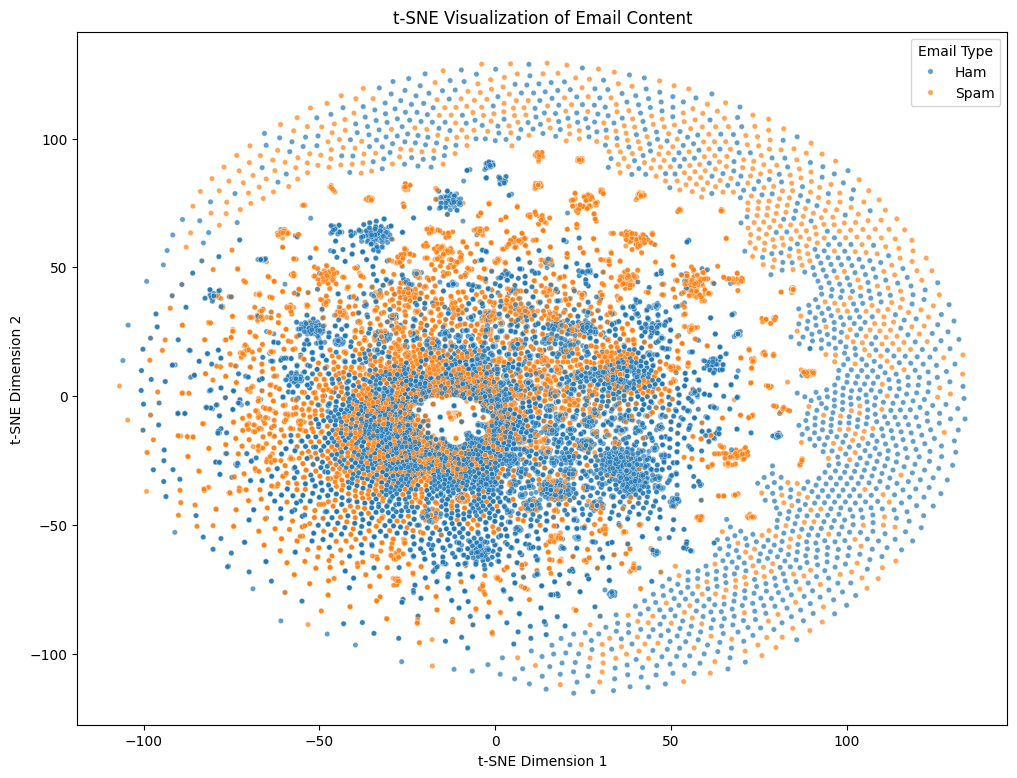

In [12]:
# Scale the TF-IDF matrix
scaler = StandardScaler(with_mean=False)
# Use the same TF-IDF matrix from the sample
X_scaled = scaler.fit_transform(tfidf_matrix)

# Initialize t-SNE
tsne = TSNE(n_components=2, init="pca", perplexity=40, learning_rate="auto", random_state=42, n_jobs=-1, verbose=0)

# Fit & transform the scaled data
embedding = tsne.fit_transform(X_scaled.toarray())


# --- T-SNE VISUALIZATION ---

# Temporary DF to let seaborn's 'hue' parameter automatically color points by label.
tsne_df = pd.DataFrame({
    "tsne_1": embedding[:, 0],
    "tsne_2": embedding[:, 1],
    "label": sample_labels.map({0: 'Ham', 1: 'Spam'})  # Use string labels for legend
})

plt.figure(figsize=(12, 9))
sns.scatterplot(
    data=tsne_df,
    x="tsne_1",
    y="tsne_2",
    hue="label",  # Add hue for color distinction
    alpha=0.7,
    s=15
)
plt.title("t-SNE Visualization of Email Content")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Email Type")
plt.show()

Not sure how helpful the the t-SNE is, but its' somewhat structured nature (groups of higher concentrations) seems to indicate that text preprocessing & TF-IDF vectorization were successful in transforming the raw text into a meaningful representation where spam and ham can be distinguished.

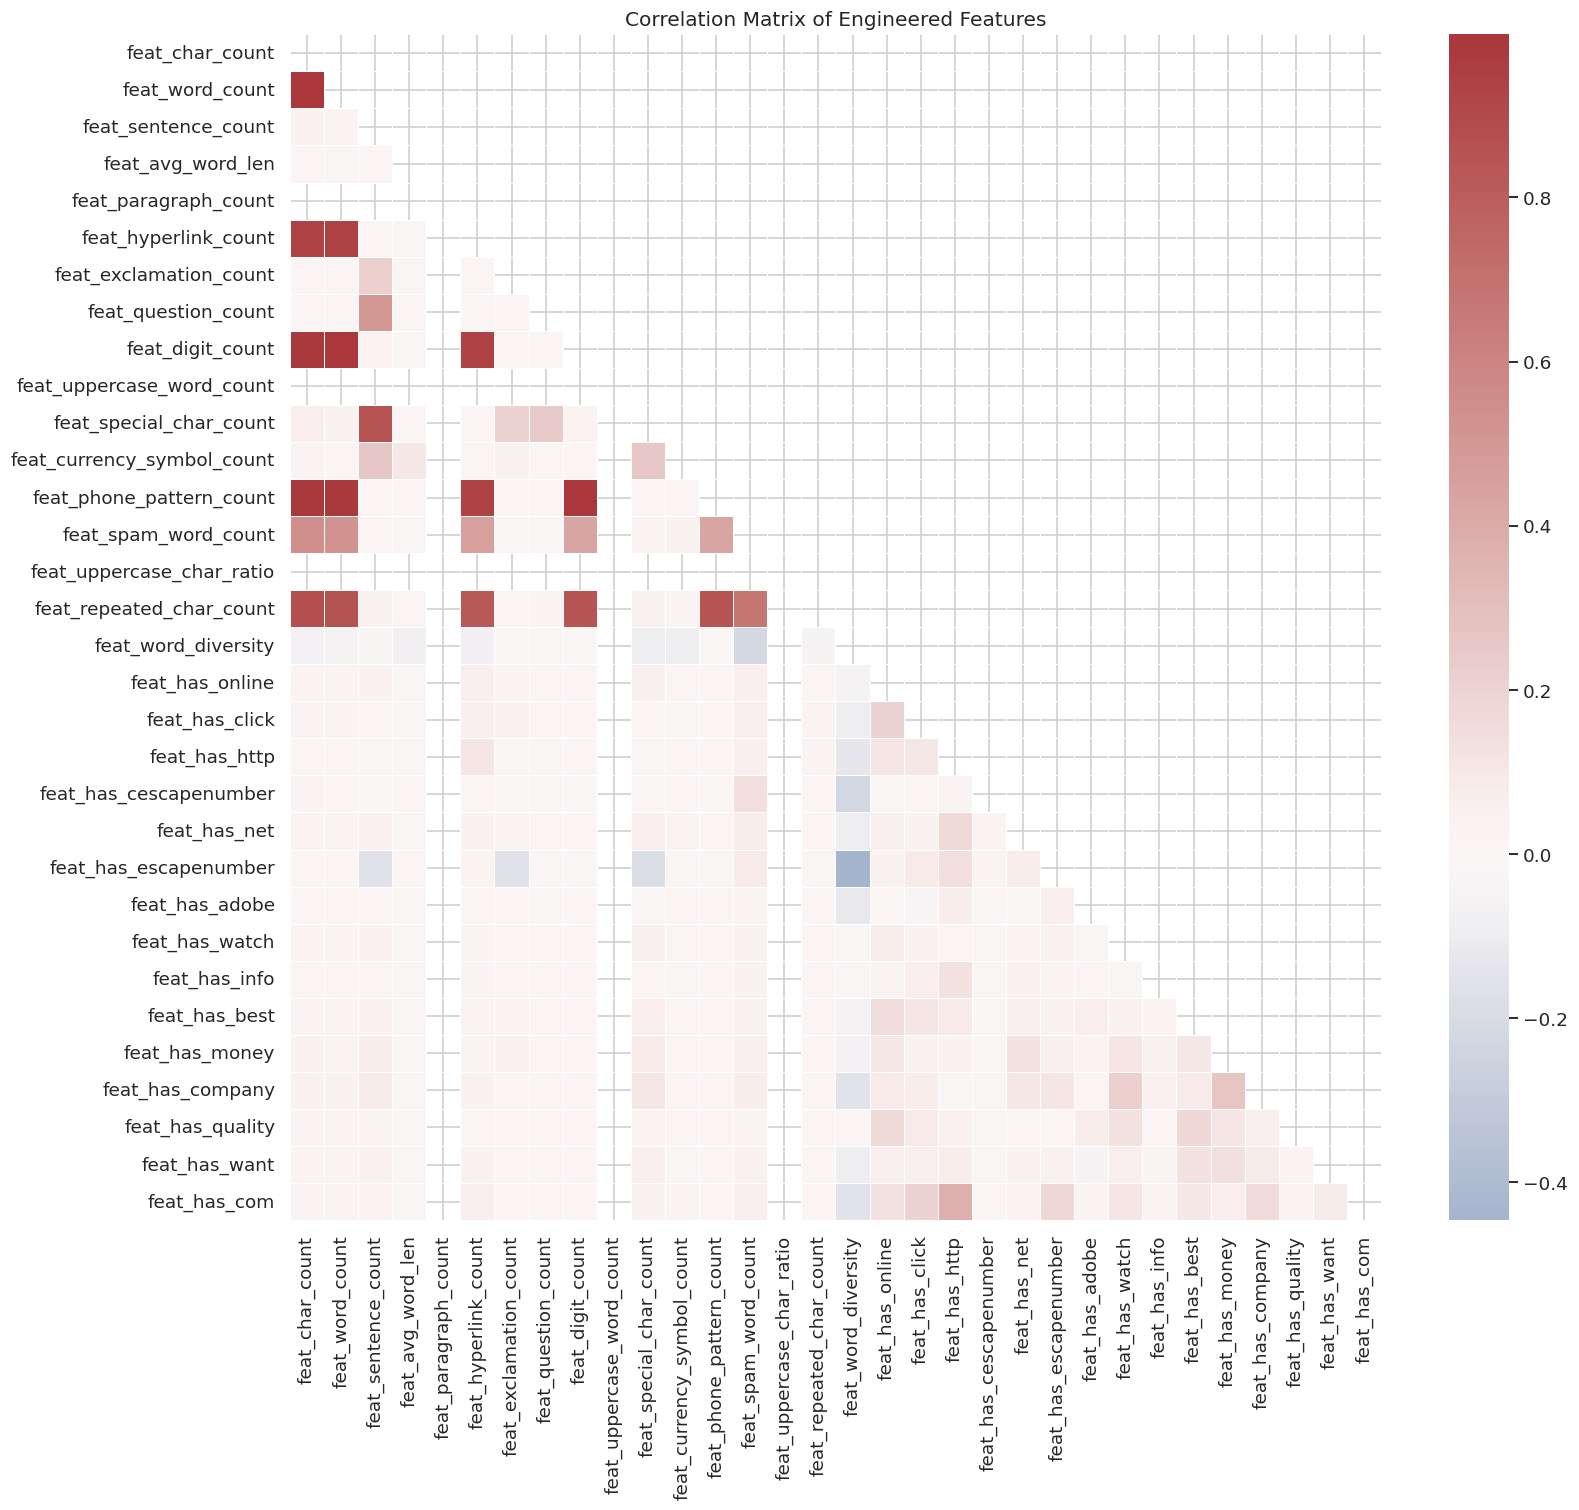

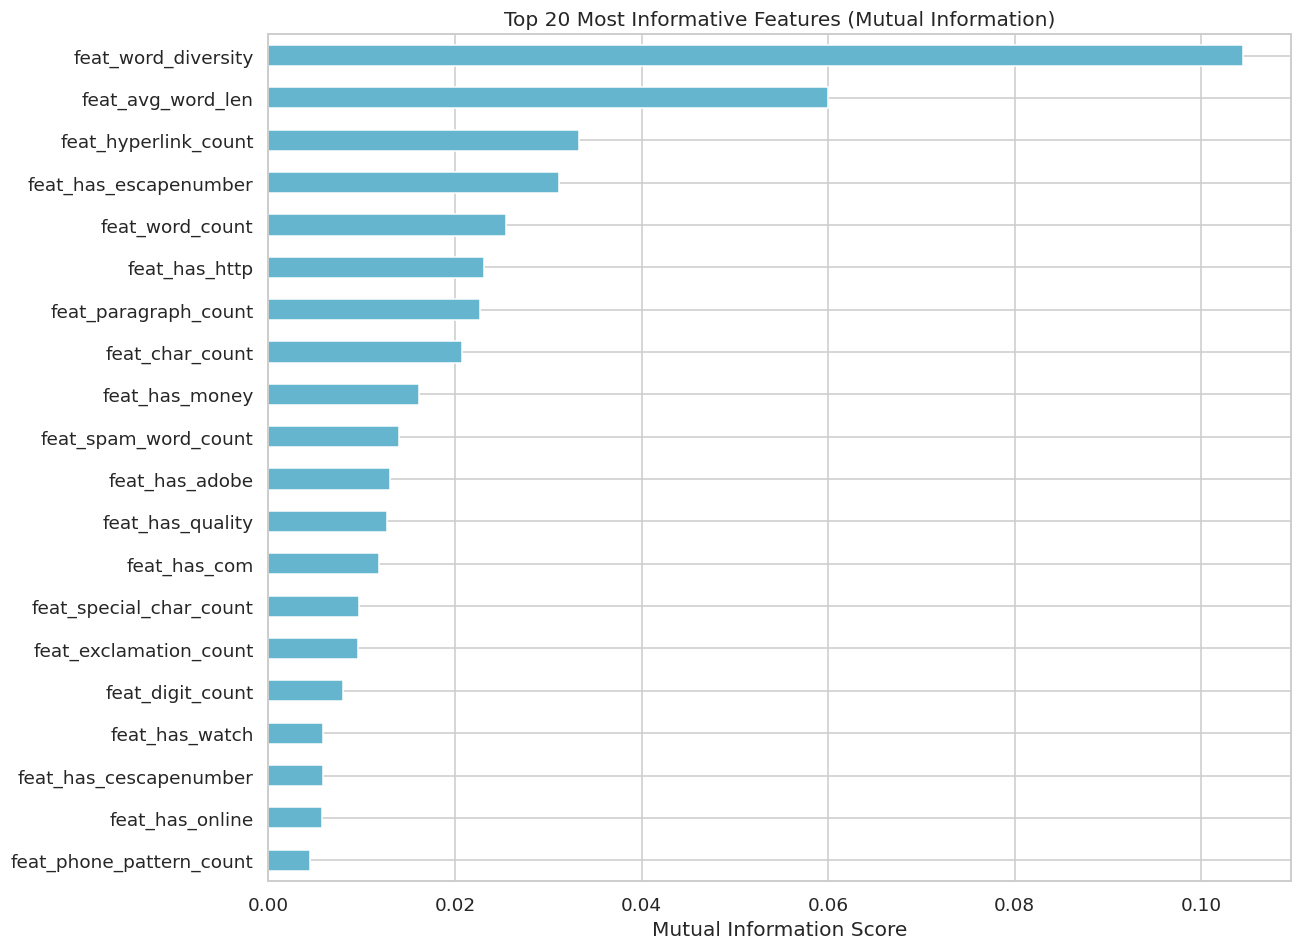


 Highly Correlated Feature Pairs (|correlation| > 0.75)


,Feature 1,Feature 2,Correlation
1,feat_char_count,feat_word_count,0.998904
21,feat_digit_count,feat_phone_pattern_count,0.998397
8,feat_word_count,feat_digit_count,0.988593
9,feat_word_count,feat_phone_pattern_count,0.987584
3,feat_char_count,feat_digit_count,0.983662
4,feat_char_count,feat_phone_pattern_count,0.982177
7,feat_word_count,feat_hyperlink_count,0.944627
16,feat_hyperlink_count,feat_phone_pattern_count,0.942311
2,feat_char_count,feat_hyperlink_count,0.941881
15,feat_hyperlink_count,feat_digit_count,0.941853



 Comparing Key Feature Statistics (Spam vs. Ham)

Average values for the 10 most informative features:


,Ham_Mean,Spam_Mean,Ratio (Spam/Ham)
feat_has_money,0.04,0.13,3.5x
feat_has_http,0.28,0.45,1.6x
feat_avg_word_len,7.65,10.61,1.4x
feat_word_diversity,0.67,0.75,1.1x
feat_paragraph_count,1.00,1.00,1.0x
feat_hyperlink_count,1.64,1.42,0.9x
feat_spam_word_count,31.40,26.54,0.8x
feat_has_escapenumber,0.71,0.58,0.8x
feat_char_count,"2,169.70","1,415.07",0.7x
feat_word_count,241.52,141.15,0.6x


In [7]:
# Correlation & Feature Informativeness
numeric_feature_cols = [c for c in df.columns if c.startswith("feat_")]

# Correlation Matrix
corr_matrix = df[numeric_feature_cols].corr()
plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap="vlag", center=0, annot=False, linewidths=.5)
plt.title("Correlation Matrix of Engineered Features")
plt.show()

# --- Mutual Information Ranking ---

X_features = df[numeric_feature_cols]
# Replace any -inf or +inf values with NaN.
X_features = X_features.replace([np.inf, -np.inf], np.nan)
# Fill all NaN values (both original and the ones we just created) with 0.
X_features = X_features.fillna(0)

y_labels = df['label']
mi_scores = mutual_info_classif(X_features, y_labels, random_state=42)
mi_series = pd.Series(mi_scores, index=X_features.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 10))
mi_series.head(20).sort_values(ascending=True).plot.barh(color="c")
plt.title("Top 20 Most Informative Features (Mutual Information)")
plt.xlabel("Mutual Information Score")
plt.show()

# --- Automated Insight Summary ---

# --- Highly Correlated Feature Pairs ---
print("\n Highly Correlated Feature Pairs (|correlation| > 0.75)")
high_corr_series = corr_matrix.where(mask).stack()
high_corr_pairs_df = high_corr_series[abs(high_corr_series) > 0.75].reset_index()
high_corr_pairs_df.columns = ['Feature 1', 'Feature 2', 'Correlation']

# Filter out pairs where the features are the same
high_corr_pairs_df = high_corr_pairs_df[high_corr_pairs_df['Feature 1'] != high_corr_pairs_df['Feature 2']]

display(high_corr_pairs_df.sort_values(by='Correlation', ascending=False))

# --- Key Feature Statistics: Spam vs. Ham ---
print("\n Comparing Key Feature Statistics (Spam vs. Ham)")
top_10_features = mi_series.head(10).index
stats_df = df.groupby('label')[top_10_features].mean().T
stats_df.columns = ['Ham_Mean', 'Spam_Mean']
stats_df['Ratio (Spam/Ham)'] = (stats_df['Spam_Mean'] / (stats_df['Ham_Mean'] + 1e-6)) # Add epsilon for stability
stats_df = stats_df.sort_values(by='Ratio (Spam/Ham)', ascending=False)

print("\nAverage values for the 10 most informative features:")
display(stats_df.style.format({
    'Ham_Mean': '{:,.2f}',
    'Spam_Mean': '{:,.2f}',
    'Ratio (Spam/Ham)': '{:,.1f}x'
}).background_gradient(cmap='viridis', subset=['Ratio (Spam/Ham)']))


---

INVESTIGATING artifacts like 'escapenumber'


(Initialy I thought it must have been generated somehow by my preprocessing somehow, and ran code that extracted emails with these strings, and provided a side by side comparison between the original text and my processed text; however, I found that these artifacts were actualy in the original raw text, despite the dataset documentation making no mention of any sanetization.)

In [8]:
# Filter the dataframe to find rows where the processed text contains 'escapenumber'
problematic_emails_df = df[df['processed_text'].str.contains("escapenumber", na=False)]

# Display the original, raw text of the first few problematic emails
for i in range(min(5, len(problematic_emails_df))):
    print("\n" + "="*80)
    print(f"RAW TEXT OF PROBLEMATIC EMAIL #{i+1}")
    print("="*80)
    # Using .iloc[i] to get the i-th email from our filtered dataframe
    print(problematic_emails_df['text'].iloc[i])


RAW TEXT OF PROBLEMATIC EMAIL #1
got ice thought look az original message ice operations mailto iceoperations intcx com sent friday october escapenumber escapenumber escapenumber escapenumber pm subject escapelong amended participant agreement dear participant receiving email identified company user administrator legal counsel signatory escapelong participant agreement serves notice intercontinentals intent amend agreement effective december escapenumber escapenumber relevant documentation attached includes contact information questions thank escapelong inc

RAW TEXT OF PROBLEMATIC EMAIL #2
yo ur wom an ne eds an escapenumber in ch ma n b e th at ma n f or h er le arn h ow here tu rn of f not ific ati ons here escapelong dy international exports ltd st regina escapenumber belize city belize escapelong 

RAW TEXT OF PROBLEMATIC EMAIL #3
author jra date escapenumber escapenumber escapenumber escapenumber escapenumber escapenumber escapenumber fri escapenumber jun escapenumber new revisi

# Model Development

In [ ]:
# Imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    matthews_corrcoef,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)

Training data shape: 155,081 samples
Testing data shape:  38,771 samples

COMPREHENSIVE EVALUATION FOR: Logistic Regression
Accuracy: 0.9766
Matthews Correlation Coefficient (MCC): 0.9531

Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      0.97      0.98     20432
        Spam       0.97      0.98      0.98     18339

    accuracy                           0.98     38771
   macro avg       0.98      0.98      0.98     38771
weighted avg       0.98      0.98      0.98     38771

Area Under ROC Curve (AUC): 0.9967


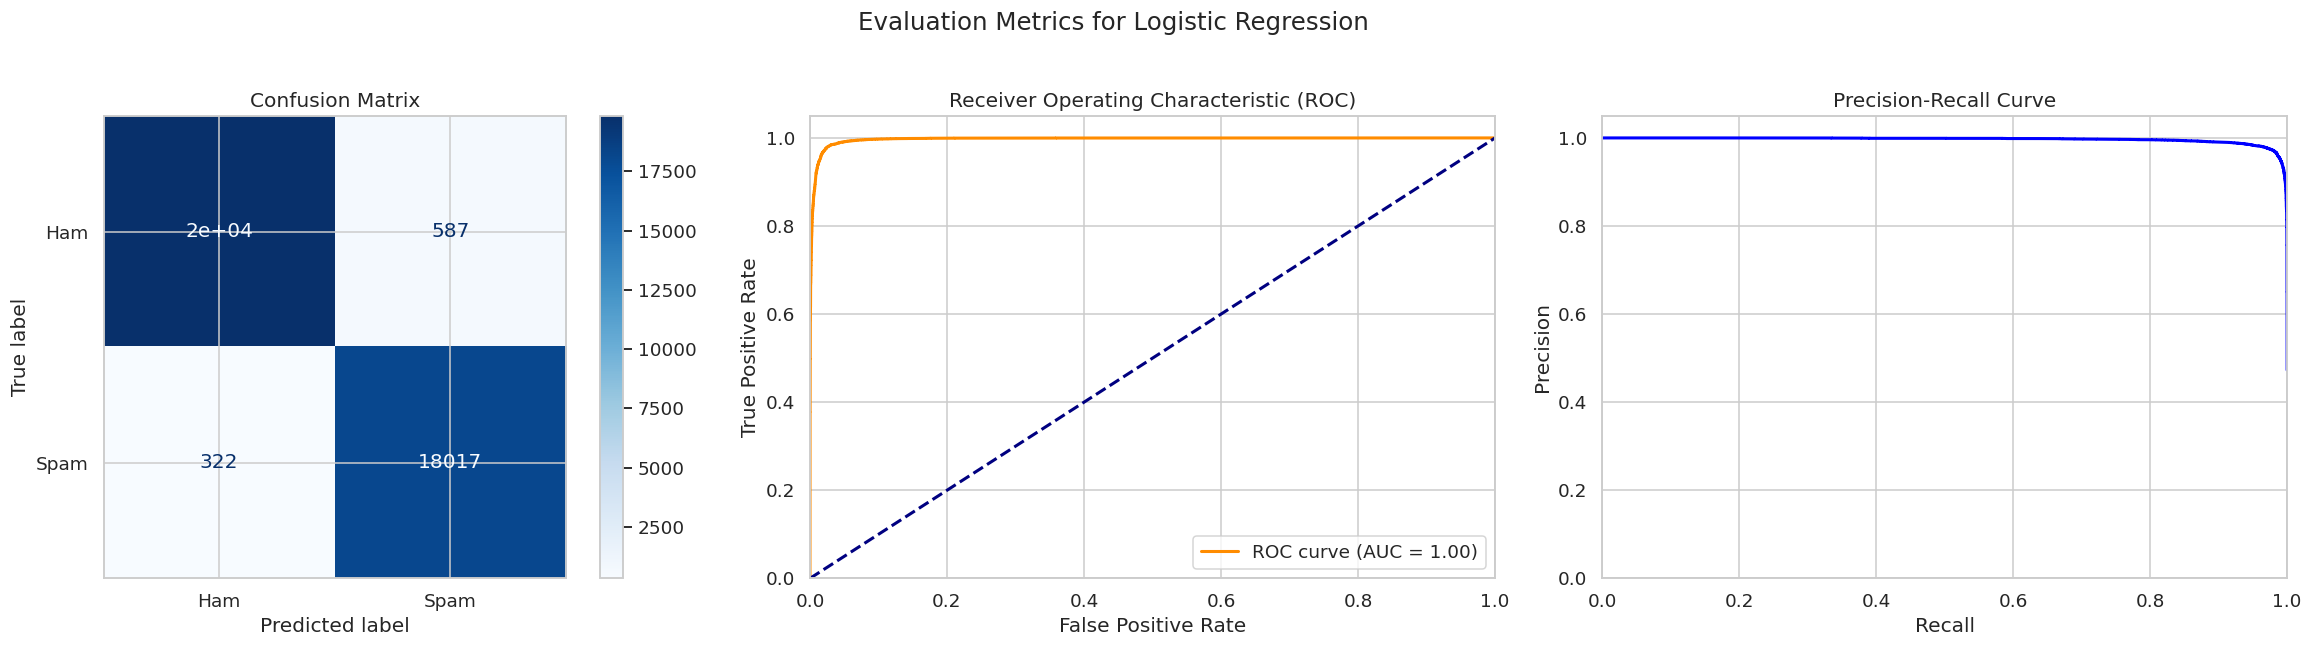


COMPREHENSIVE EVALUATION FOR: Multinomial Naive Bayes
Accuracy: 0.9436
Matthews Correlation Coefficient (MCC): 0.8872

Classification Report:
              precision    recall  f1-score   support

         Ham       0.93      0.96      0.95     20432
        Spam       0.96      0.92      0.94     18339

    accuracy                           0.94     38771
   macro avg       0.94      0.94      0.94     38771
weighted avg       0.94      0.94      0.94     38771

Area Under ROC Curve (AUC): 0.9910


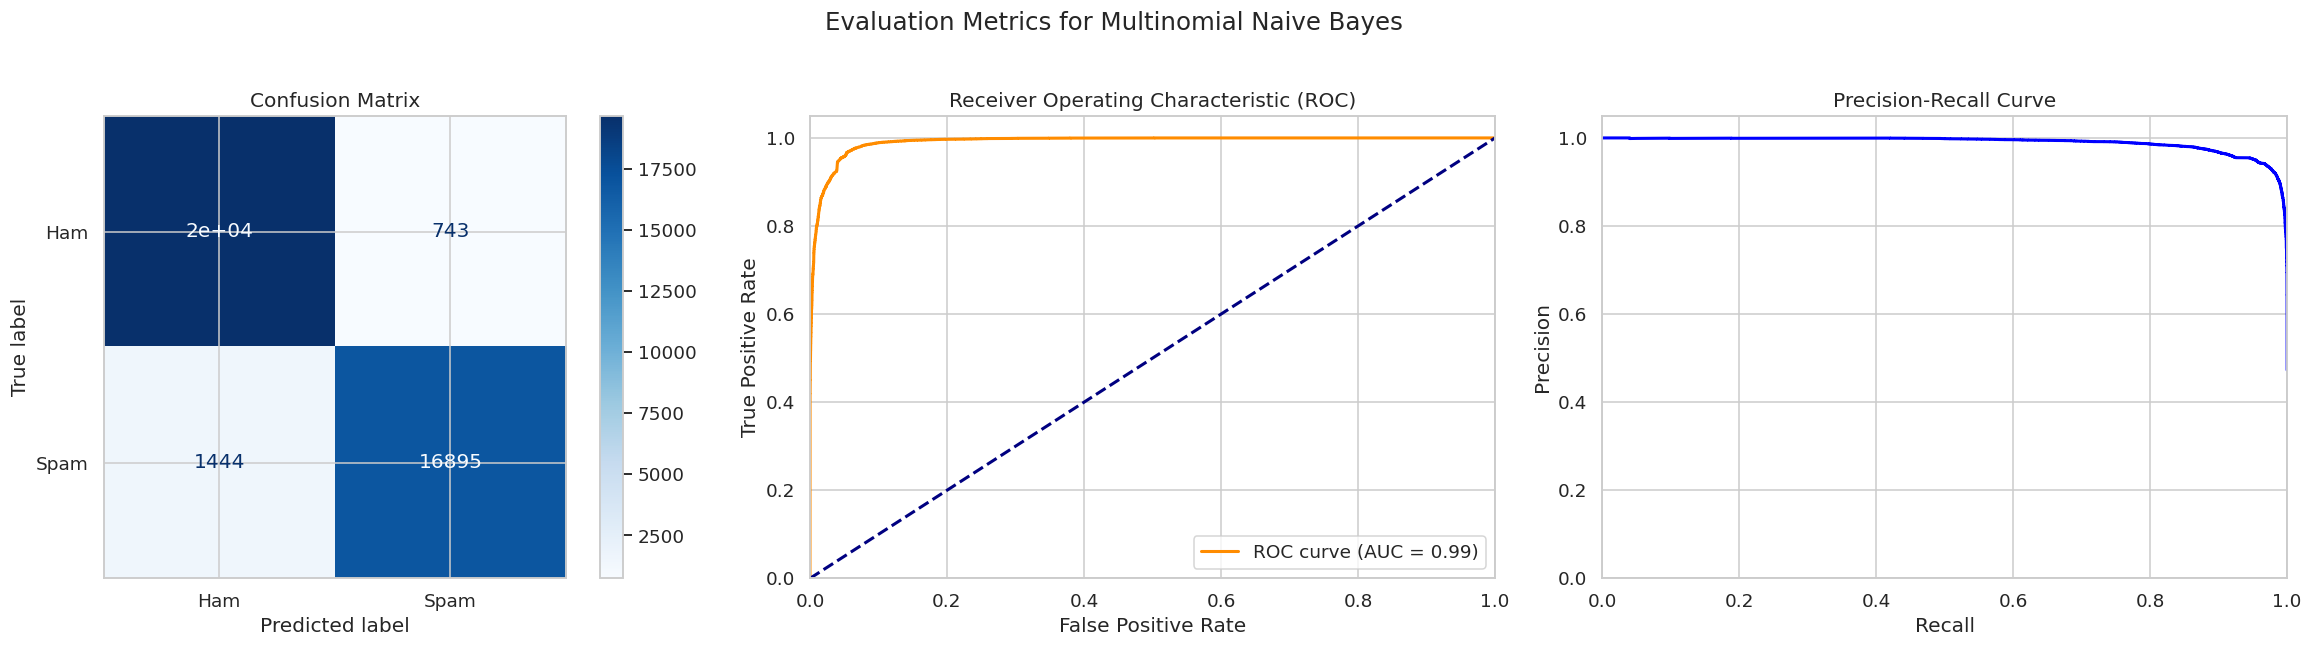

In [31]:
# Use stratify to ensure the same class distribution in train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df['processed_text'],
    df['label'],
    test_size=0.2,       # Use 20% of the data for testing
    random_state=42,
    stratify=df['label']
)

print(f"Training data shape: {X_train.shape[0]:,} samples")
print(f"Testing data shape:  {X_test.shape[0]:,} samples")


# --- Build & Train Pipelines ---

# We'll create a pipeline for each model. This is best practice as it contains the
# vectorizer and the classifier, preventing data leakage from the test set.

# --- Pipeline 1: Logistic Regression ---
logreg_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, stop_words='english', ngram_range=(1,2))),
    ('clf', LogisticRegression(solver='liblinear', random_state=42, C=1))
])
logreg_pipeline.fit(X_train, y_train)


# --- Pipeline 2: Multinomial Naive Bayes ---
nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, stop_words='english', ngram_range=(1,2))),
    ('clf', MultinomialNB())
])
nb_pipeline.fit(X_train, y_train)


# --- Evaluate Models ---

#  Evaluation Function
def evaluate_model(pipeline, model_name):
    """Calculates and displays a comprehensive set of evaluation metrics and plots."""
    print("\n" + "="*80)
    print(f"COMPREHENSIVE EVALUATION FOR: {model_name}")
    print("="*80)

    # Basic Predictions & Metrics
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

    # Probability-based Metrics & Plots
    # Get the probability of the positive class (Spam)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_proba)
    print(f"Area Under ROC Curve (AUC): {auc_score:.4f}")

    # Generate & Display Plots
    fig, axes = plt.subplots(1, 3, figsize=(22, 6))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
    disp.plot(cmap=plt.cm.Blues, ax=axes[0])
    axes[0].set_title(f'Confusion Matrix')

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Receiver Operating Characteristic (ROC)')
    axes[1].legend(loc="lower right")

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    axes[2].plot(recall, precision, color='blue', lw=2)
    axes[2].set_xlabel('Recall')
    axes[2].set_ylabel('Precision')
    axes[2].set_ylim([0.0, 1.05])
    axes[2].set_xlim([0.0, 1.0])
    axes[2].set_title('Precision-Recall Curve')

    plt.suptitle(f'Evaluation Metrics for {model_name}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

evaluate_model(logreg_pipeline, "Logistic Regression")
evaluate_model(nb_pipeline, "Multinomial Naive Bayes")

EXPERIMENT 1: ADDING ENGINEERED FEATURES


Step 3: Training the new Logistic Regression model...

--------------------------------------------------
Evaluation for: Logistic Regression with Engineered Features
--------------------------------------------------
Accuracy: 0.9776

Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      0.97      0.98     20432
        Spam       0.97      0.98      0.98     18339

    accuracy                           0.98     38771
   macro avg       0.98      0.98      0.98     38771
weighted avg       0.98      0.98      0.98     38771

Advanced Metrics:
Matthews Corr. Coef. (MCC): 0.9552
ROC AUC Score:              0.9970
Log Loss:                   0.0780

Confusion Matrix:


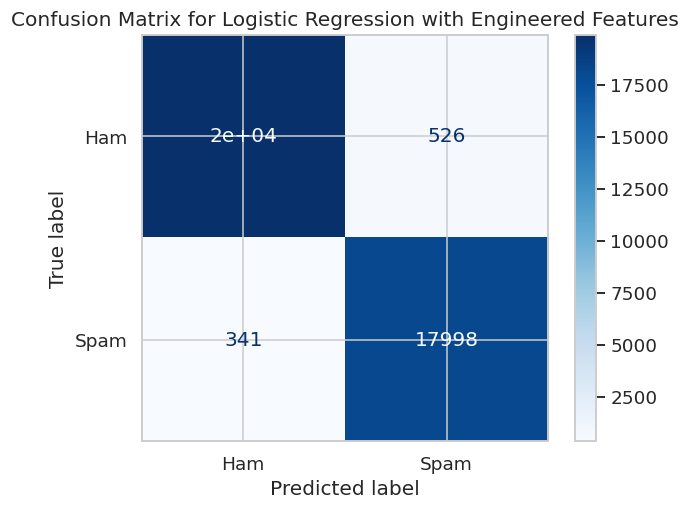

In [32]:
# Recreate Engineered Features
raw_text = df["text"].astype(str)
processed_tokens = df["processed_text"].str.split().fillna("").apply(list)
features = pd.DataFrame(index=df.index)

features["feat_char_count"] = raw_text.str.len()
features["feat_word_count"] = processed_tokens.str.len()
features["feat_avg_word_len"] = features["feat_char_count"] / features["feat_word_count"].clip(lower=1)
features["feat_word_diversity"] = processed_tokens.apply(lambda x: len(set(x))) / features["feat_word_count"].clip(lower=1)
features["feat_paragraph_count"] = raw_text.str.count(r'\n\n') + 1
features["feat_hyperlink_count"] = raw_text.str.lower().str.count(r"(http|www|\.com)")
features["feat_special_char_count"] = raw_text.str.count(fr"[{re.escape(string.punctuation)}]")
features["feat_digit_count"] = raw_text.str.count(r"\d")

top_keywords = ['escapenumber', 'price', 'quality', 'professional', 'save', 'offer', 'site', 'bescapenumber', 'cescapenumber']
for word in top_keywords:
    features[f"feat_has_{word}"] = df["processed_text"].str.contains(fr"\b{word}\b", regex=True).astype(int)

features = features.fillna(0)
df_features = pd.concat([df[['processed_text', 'label']], features], axis=1)


# Select Top Features & Prepare for Pipeline
numeric_features = [
    'feat_word_diversity', 'feat_avg_word_len', 'feat_hyperlink_count', 'feat_has_escapenumber',
    'feat_word_count', 'feat_paragraph_count', 'feat_char_count', 'feat_has_price',
    'feat_has_quality', 'feat_has_professional', 'feat_special_char_count', 'feat_has_save',
    'feat_digit_count', 'feat_has_bescapenumber', 'feat_has_offer'
]

preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(max_features=10000, stop_words='english', ngram_range=(1,2)), 'processed_text'),
        ('numeric', StandardScaler(), numeric_features)
    ],
    remainder='drop'
)


# Build & Train New Pipeline
logreg_full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(solver='liblinear', random_state=42, C=1))
])

X = df_features.drop('label', axis=1)
y = df_features['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\nStep 3: Training the new Logistic Regression model...")
logreg_full_pipeline.fit(X_train, y_train)


# Evaluate New Model
def evaluate_model(pipeline, model_name, X_test_data=X_test, y_test_data=y_test):
    """Calculates and displays a comprehensive set of evaluation metrics."""
    print("\n" + "-"*50)
    print(f"Evaluation for: {model_name}")
    print("-"*50)

    # Get class predictions
    y_pred = pipeline.predict(X_test_data)

    # Standard Metrics
    accuracy = accuracy_score(y_test_data, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test_data, y_pred, target_names=['Ham', 'Spam']))

    # Advanced Metrics
    print("Advanced Metrics:")
    # Matthews Correlation Coefficient (MCC): Robust measure for binary classification
    mcc = matthews_corrcoef(y_test_data, y_pred)
    print(f"Matthews Corr. Coef. (MCC): {mcc:.4f}")

    # ROC AUC & Log Loss require prediction probabilities
    # Get probability of the positive class (Spam)
    y_pred_proba = pipeline.predict_proba(X_test_data)[:, 1]

    # Area Under the ROC Curve (AUC)
    auc = roc_auc_score(y_test_data, y_pred_proba)
    print(f"ROC AUC Score:              {auc:.4f}")

    # Logarithmic Loss
    ll = log_loss(y_test_data, y_pred_proba)
    print(f"Log Loss:                   {ll:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test_data, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

# Evaluate the new model using the enhanced function
evaluate_model(logreg_full_pipeline, "Logistic Regression with Engineered Features")

EXPERIMENT 2: HYPERPARAMETER TUNING WITH GRIDSEARCHCV

This will test 6 combinations of parameters.
Fitting 3 folds for each of 6 candidates, totalling 18 fits

Best parameters found: {'clf__C': 10, 'clf__penalty': 'l1'}
Best cross-validation F1-score: 0.9806

--------------------------------------------------
Evaluation for: Tuned Logistic Regression
--------------------------------------------------
Accuracy: 0.9835

Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      0.98      0.98     20432
        Spam       0.98      0.98      0.98     18339

    accuracy                           0.98     38771
   macro avg       0.98      0.98      0.98     38771
weighted avg       0.98      0.98      0.98     38771

Advanced Metrics:
Matthews Corr. Coef. (MCC): 0.9668
ROC AUC Score:              0.9979
Log Loss:                   0.0550

Confusion Matrix:


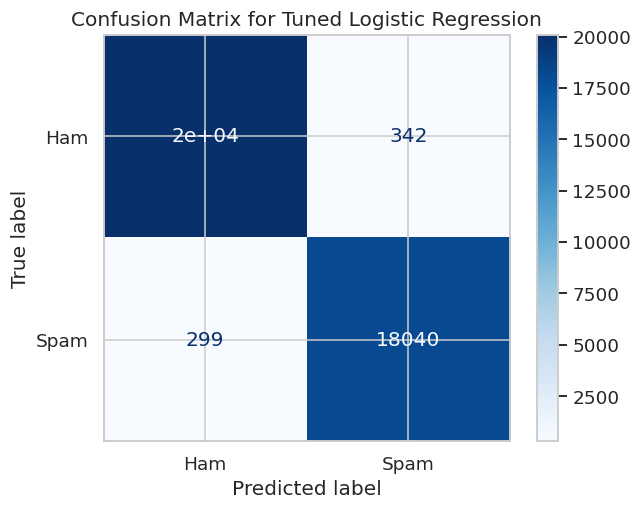

In [33]:
# EXPERIMENT 2: HYPERPARAMETER TUNING WITH GRIDSEARCHCV

# --- 1. Use the SAME pipeline from Experiment 1 ---
# We are tuning the hyperparameters of the classifier WITHIN our existing pipeline.
# The pipeline object 'logreg_full_pipeline' already contains our preprocessor & classifier.
# We just need to define the parameters we want to search for.

# --- 2. Define the Parameter Grid ---
# This dictionary tells GridSearchCV what to test.
# The keys must be in the format: '<step_name>__<parameter_name>'
# Our classifier step is named 'clf'.
param_grid = {
    # Test different regularization strengths
    'clf__C': [0.1, 1, 10],
    # Test different types of regularization penalty
    'clf__penalty': ['l1', 'l2']
}

# We already have our X_train and y_train from the previous step.

# Set up & Run GridSearchCV
print("This will test", len(param_grid['clf__C']) * len(param_grid['clf__penalty']), "combinations of parameters.")

# Set up the grid search object
grid_search = GridSearchCV(
    estimator=logreg_full_pipeline,
    param_grid=param_grid,
    cv=3, # 3-fold cross-validation
    n_jobs=-1, # Use all availale CPUs
    scoring='f1_macro', # find the parameters that maximize the F1-score
    verbose=2 # This will print progress updates
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# --- 4. Analyze the Results ---

# Print the best parameters found
print(f"\nBest parameters found: {grid_search.best_params_}")

# Print the best cross-validation score
print(f"Best cross-validation F1-score: {grid_search.best_score_:.4f}")


# --- 5. Evaluate the BEST Model on the Test Set ---
# The 'grid_search' object now contains the best model found ('best_estimator_')
evaluate_model(grid_search.best_estimator_, "Tuned Logistic Regression")

EXPERIMENT 3: LightGBM

[LightGBM] [Info] Number of positive: 73353, number of negative: 81728
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 9.468771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1845878
[LightGBM] [Info] Number of data points in the train set: 155081, number of used features: 9958
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.472998 -> initscore=-0.108113
[LightGBM] [Info] Start training from score -0.108113

--------------------------------------------------
Evaluation for: LightGBM Classifier
--------------------------------------------------
Accuracy: 0.9696

Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      0.96      0.97     20432
        Spam       0.96      0.98      0.97     18339

    accuracy                           0.97     38771
   macro avg       0.97      0.97     

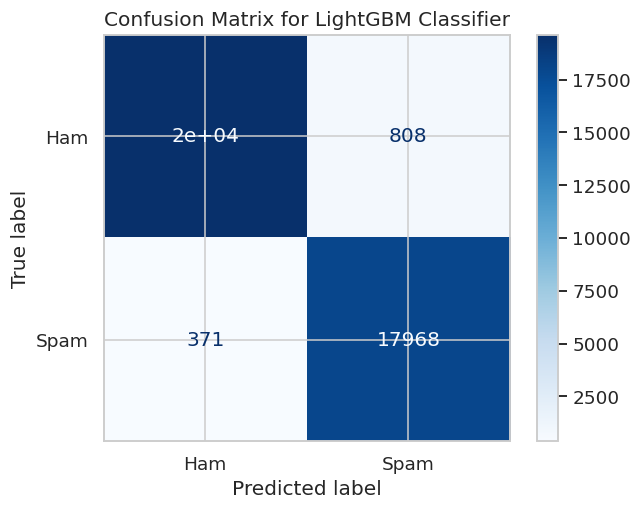

In [34]:
# --- Build LightGBM Pipeline ---
# Use the same 'preprocessor' from the previous experiments.
# The only change is swapping the classifier at the end of the pipeline.

lgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), # Using the same ColumnTransformer
    ('clf', lgb.LGBMClassifier(random_state=42)) # The new classifier
])

# Use same X_train, y_train, X_test, and y_test sets.

# Train the LightGBM Model
lgbm_pipeline.fit(X_train, y_train)

# Evaluate LightGBM Model
# We use our trusted evaluation function to see how it performs on the test set.
evaluate_model(lgbm_pipeline, "LightGBM Classifier")

Grid Search Hyperparameter Tuning with LGBM


 PATH 1: HYPERPARAMETER TUNING THE LIGHTGBM MODEL
Step 1: Setting up GridSearchCV for LightGBM...
This will perform 24 model fits in total.
This step will take a significant amount of time. Please be patient.
Progress will be printed below thanks to 'verbose=2'.
Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 73353, number of negative: 81728
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 8.333022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1845830
[LightGBM] [Info] Number of data points in the train set: 155081, number of used features: 9958
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.472998 -> initscore=-0.108113
[LightGBM] [Info] Start training from score -0.108113

Step 2: Analyzing the tuning results...
✅ LightGBM grid search complete.

Best parameters found for LightGBM: {'clf__learning_rate': 0.1, 'clf__n_estimators': 200, 'clf__num_leaves': 40}
Best cross-validation F1-score: 0.9819

Step 3: Evaluating the best found LightGBM model on the test set...

--------------------------------------------------
Evaluation for: Tuned LightGBM Classifier
----------------------------------------------

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Accuracy: 0.9827

Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      0.98      0.98     20432
        Spam       0.97      0.99      0.98     18339

    accuracy                           0.98     38771
   macro avg       0.98      0.98      0.98     38771
weighted avg       0.98      0.98      0.98     38771

Advanced Metrics:
Matthews Corr. Coef. (MCC): 0.9653


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


ROC AUC Score:              0.9986
Log Loss:                   0.0538

Confusion Matrix:


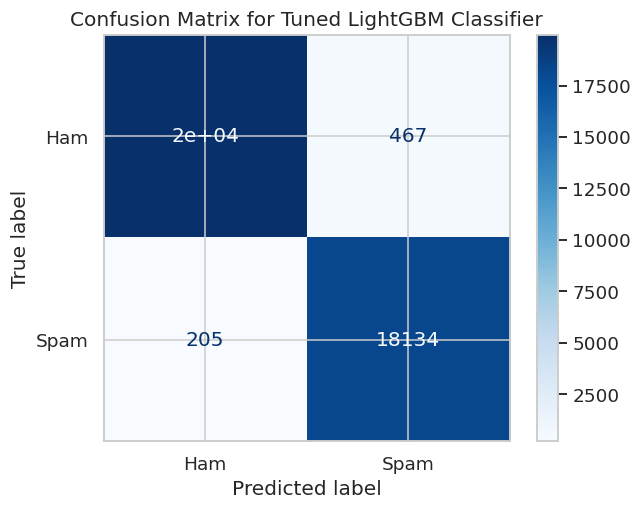


Total time taken for this experiment: 79.02 minutes.


In [ ]:
# Define the LightGBM Parameter Grid ---
# We will tune some of the most impactful hyperparameters for LightGBM.
param_grid_lgbm = {
    # Number of decision trees to build
    'clf__n_estimators': [100, 200],
    # The rate at which each new tree corrects the previous ones' errors
    'clf__learning_rate': [0.05, 0.1],
    # Maximum number of leaves in one tree (controls complexity)
    'clf__num_leaves': [31, 40]
}

# We already have our X_train & y_train data ready.

# Set up & Run GridSearchCV
total_fits = (
    len(param_grid_lgbm['clf__n_estimators']) *
    len(param_grid_lgbm['clf__learning_rate']) *
    len(param_grid_lgbm['clf__num_leaves']) *
    3  # 3 for the number of cross-validation folds (cv=3)
)

# Set up the grid search object
# verbose=2 will give us detailed progress updates
grid_search_lgbm = GridSearchCV(
    estimator=lgbm_pipeline,
    param_grid=param_grid_lgbm,
    cv=3,
    n_jobs=-1,
    scoring='f1_macro',
    verbose=2
)

# Fit the grid search to the training data
grid_search_lgbm.fit(X_train, y_train)

# --- 4. Analyze the Results ---

# Print the best parameters found
print(f"\nBest parameters found for LightGBM: {grid_search_lgbm.best_params_}")

# Print the best cross-validation score
print(f"Best cross-validation F1-score: {grid_search_lgbm.best_score_:.4f}")


# --- 5. Evaluate the BEST Tuned LightGBM on the Test Set ---
evaluate_model(grid_search_lgbm.best_estimator_, "Tuned LightGBM Classifier")

[LightGBM] [Info] Number of positive: 73353, number of negative: 81728
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 9.597556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1845878
[LightGBM] [Info] Number of data points in the train set: 155081, number of used features: 9958
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.472998 -> initscore=-0.108113
[LightGBM] [Info] Start training from score -0.108113

--------------------------------------------------
Evaluation for: Tuned LightGBM Classifier
--------------------------------------------------
Accuracy: 0.9830

Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      0.98      0.98     20432
        Spam       0.98      0.99      0.98     18339

    accuracy                           0.98     38771
   macro avg       0.98      0.9

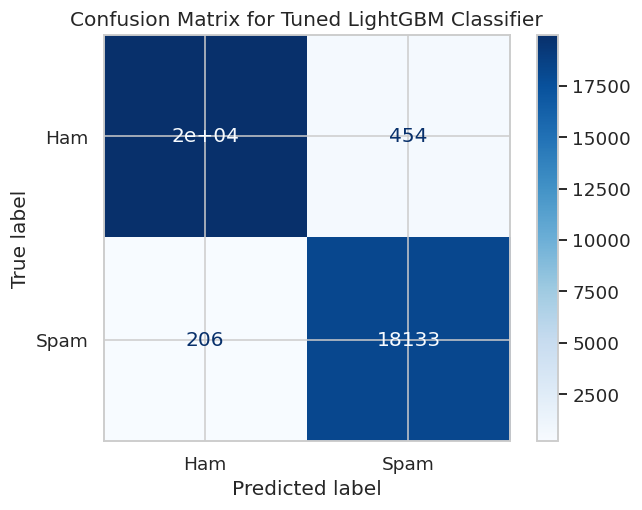

In [35]:
# Define the best parameters
best_params = {
    'learning_rate': 0.1,
    'n_estimators': 200,
    'num_leaves': 40
}

# Create new pipeline with those parameters
final_lgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', lgb.LGBMClassifier(random_state=42, **best_params)) # Unpack params here
])

# 3. Fit & evaluate
final_lgbm_pipeline.fit(X_train, y_train)
evaluate_model(final_lgbm_pipeline, "Tuned LightGBM Classifier")

Save models to Google Drive

In [14]:
# Mount Google Drive
drive.mount('/content/drive')

# Define File Path
PROJECT_PATH = '/content/drive/My Drive/Spam_Classifier_Project'

# Create directory
os.makedirs(PROJECT_PATH, exist_ok=True)

# Define paths for each file being saved
logreg_model_path = os.path.join(PROJECT_PATH, 'tuned_logistic_regression_model.joblib')
lgbm_model_path = os.path.join(PROJECT_PATH, 'tuned_lightgbm_model.joblib')
features_df_path = os.path.join(PROJECT_PATH, 'processed_features_dataframe.parquet')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 'grid_search' holds the tuned Logistic Regression results
joblib.dump(grid_search.best_estimator_, logreg_model_path)

# 'grid_search_lgbm' holds the tuned LightGBM results
joblib.dump(grid_search_lgbm.best_estimator_, lgbm_model_path)

# Save full DF with Features
# Parquet is a fast and efficient format for this.
df_features.to_parquet(features_df_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

--- Verification Test ---
Sample Email's True Label: Spam
Model's Prediction:        Spam
Model's Confidence (Proba): 100.00%


Save with timestaps

In [36]:
# Create Unique Timestamp for the Current Run
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Create a New, Run-Specific sub-folder
RUN_SPECIFIC_PATH = os.path.join(BASE_PROJECT_PATH, f"run_{timestamp}")
os.makedirs(RUN_SPECIFIC_PATH, exist_ok=True)

# Define File Paths in  New Directory
logreg_model_path = os.path.join(RUN_SPECIFIC_PATH, 'tuned_logistic_regression_model.joblib')
lgbm_model_path = os.path.join(RUN_SPECIFIC_PATH, 'tuned_lightgbm_model.joblib')
features_df_path = os.path.join(RUN_SPECIFIC_PATH, 'processed_features_dataframe.parquet')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Creating a new directory for this run at: /content/drive/My Drive/Spam_Classifier_Project/run_2025-06-12_04-51-23
Models will be saved to: /content/drive/My Drive/Spam_Classifier_Project/run_2025-06-12_04-51-23/tuned_logistic_regression_model.joblib
Features will be saved to: /content/drive/My Drive/Spam_Classifier_Project/run_2025-06-12_04-51-23/processed_features_dataframe.parquet


GloVe & WORD2VEC (with CBOW & Skip-gram)

[==================================================] 100.0% 128.1/128.1MB downloaded
RUNNING EXPERIMENT FOR: Word2Vec - CBOW


  0%|          | 0/193852 [00:00<?, ?it/s]

Evaluation for: Logistic Regression (Word2Vec - CBOW)
Accuracy: 0.7615

Classification Report:
              precision    recall  f1-score   support

         Ham       0.77      0.79      0.78     20432
        Spam       0.75      0.74      0.74     18339

    accuracy                           0.76     38771
   macro avg       0.76      0.76      0.76     38771
weighted avg       0.76      0.76      0.76     38771



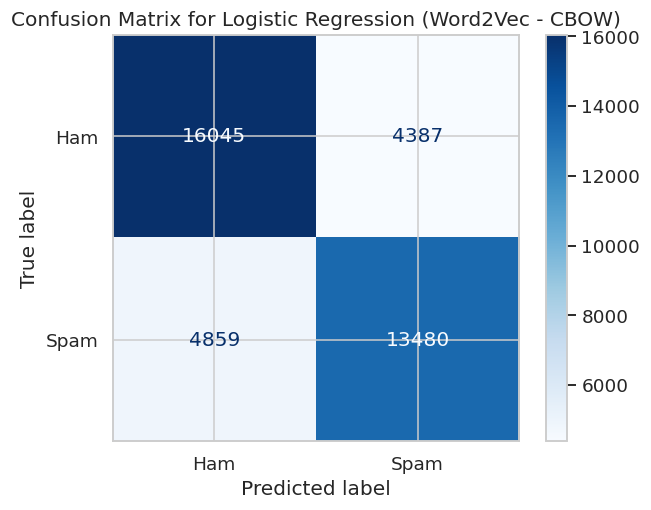

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 73353, number of negative: 81728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 155081, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.472998 -> initscore=-0.108113
[LightGBM] [Info] Start training from score -0.108113
Evaluation for: LightGBM (Word2Vec - CBOW)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Accuracy: 0.8798

Classification Report:
              precision    recall  f1-score   support

         Ham       0.88      0.89      0.89     20432
        Spam       0.88      0.87      0.87     18339

    accuracy                           0.88     38771
   macro avg       0.88      0.88      0.88     38771
weighted avg       0.88      0.88      0.88     38771



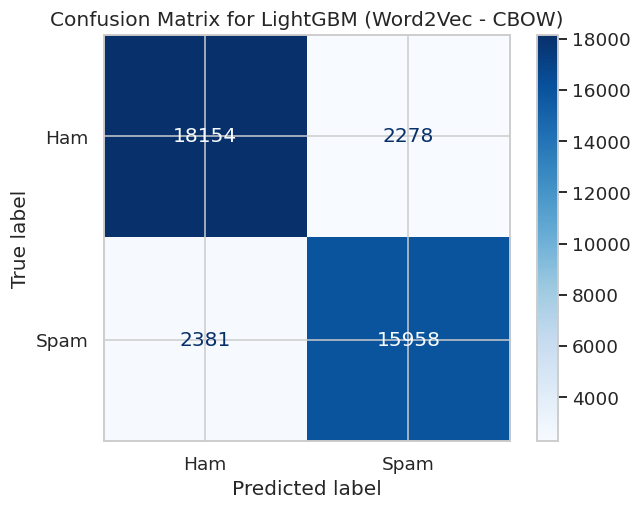

RUNNING EXPERIMENT FOR: Word2Vec - Skip-gram


  0%|          | 0/193852 [00:00<?, ?it/s]

Evaluation for: Logistic Regression (Word2Vec - Skip-gram)
Accuracy: 0.7615

Classification Report:
              precision    recall  f1-score   support

         Ham       0.77      0.79      0.78     20432
        Spam       0.75      0.74      0.74     18339

    accuracy                           0.76     38771
   macro avg       0.76      0.76      0.76     38771
weighted avg       0.76      0.76      0.76     38771



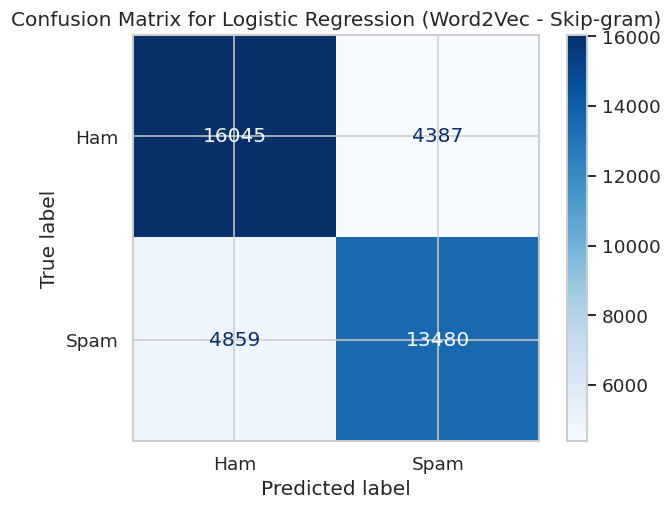

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 73353, number of negative: 81728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 155081, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.472998 -> initscore=-0.108113
[LightGBM] [Info] Start training from score -0.108113
Evaluation for: LightGBM (Word2Vec - Skip-gram)
Accuracy: 0.8798

Classification Report:
              precision    recall  f1-score   support

         Ham       0.88      0.89      0.89     20432
        Spam       0.88      0.87      0.87     18339

    accuracy                           0.88     38771
   macro avg       0.88      0.88      0.88     38771
weighted avg       0.88      0.88      0.88     38771



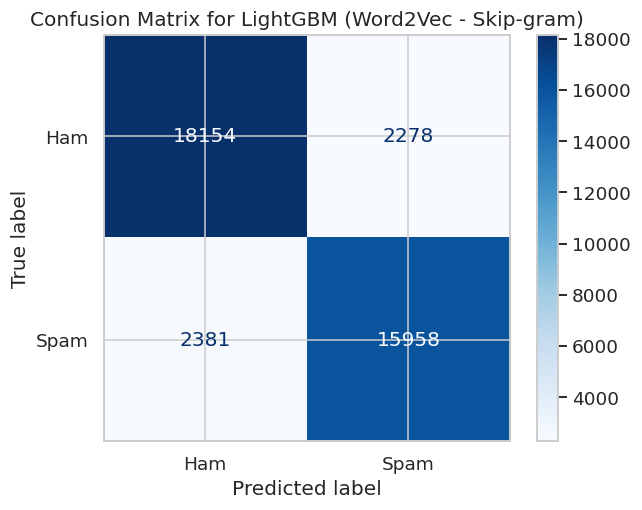

RUNNING EXPERIMENT FOR: GloVe


  0%|          | 0/193852 [00:00<?, ?it/s]

Evaluation for: Logistic Regression (GloVe)
Accuracy: 0.8874

Classification Report:
              precision    recall  f1-score   support

         Ham       0.89      0.90      0.89     20432
        Spam       0.89      0.88      0.88     18339

    accuracy                           0.89     38771
   macro avg       0.89      0.89      0.89     38771
weighted avg       0.89      0.89      0.89     38771



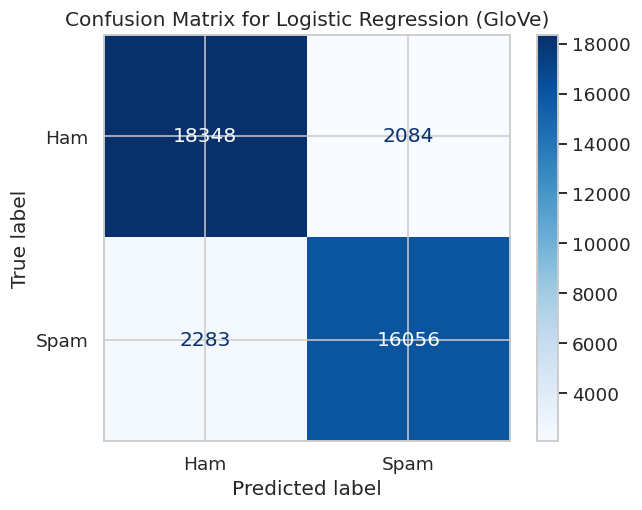

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 73353, number of negative: 81728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 155081, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.472998 -> initscore=-0.108113
[LightGBM] [Info] Start training from score -0.108113
Evaluation for: LightGBM (GloVe)
Accuracy: 0.9613

Classification Report:


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


              precision    recall  f1-score   support

         Ham       0.96      0.96      0.96     20432
        Spam       0.96      0.96      0.96     18339

    accuracy                           0.96     38771
   macro avg       0.96      0.96      0.96     38771
weighted avg       0.96      0.96      0.96     38771



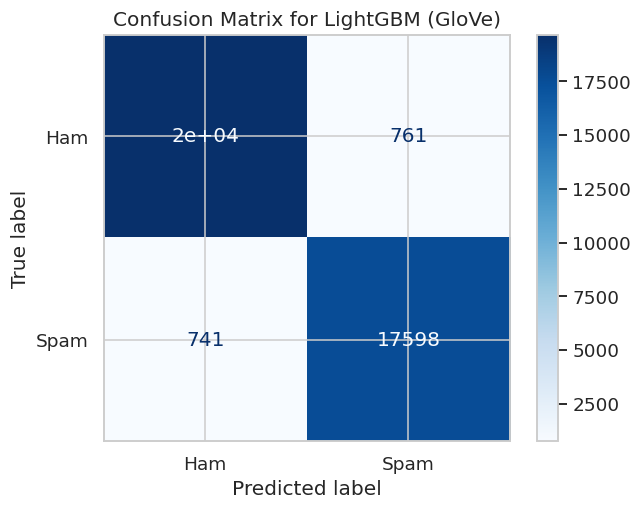

In [ ]:
import gensim
import gensim.downloader as api

# --- Prepare Data ---
# We need the text in a tokenized format (a list of lists of words)
# This was created in EDA as 'processed_text'
tokenized_text = df['processed_text'].str.split().fillna("").tolist()
y = df['label']


# --- Define Helper Functions ---
# with a fitted model and test data, instead of a pipeline.
def evaluate_model_v2(model, model_name, X_test, y_test):
    """Calculates and displays evaluation metrics for a given fitted model."""
    print(f"Evaluation for: {model_name}")
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

def create_document_vector(doc, model):
    """Creates a single vector for a document by averaging its word vectors."""
    # Standardize access to the keyed vectors
    keyed_vectors = model.wv if hasattr(model, 'wv') else model
    # Create a list of vectors for words in the doc that are in the model's vocab
    vectors = [keyed_vectors[word] for word in doc if word in keyed_vectors]
    # If no words in the document are in the vocabulary, return a zero vector.
    if not vectors:
        return np.zeros(keyed_vectors.vector_size)
    return np.mean(vectors, axis=0)

def run_embedding_experiment(embedding_model, model_name, tokenized_text, y):
    """Runs a full experiment for a given embedding model."""
    print(f"RUNNING EXPERIMENT FOR: {model_name}")

    # Create document vectors for entire dataset (tqdm for progress bar)
    X_features = np.array([create_document_vector(doc, embedding_model) for doc in tqdm(tokenized_text)])
    # Split data for training & testing
    X_train, X_test, y_train, y_test = train_test_split(
        X_features, y, test_size=0.2, random_state=42, stratify=y
    )


    # Train & evaluate 2 best classifiers
    # Classifier 1: Tuned Logistic Regression
    logreg = LogisticRegression(solver='liblinear', random_state=42, C=10, penalty='l1') # Use our best params
    logreg.fit(X_train, y_train)
    evaluate_model_v2(logreg, f"Logistic Regression ({model_name})", X_test, y_test)


    # Classifier 2: Tuned LightGBM
    lgbm = lgb.LGBMClassifier(random_state=42, learning_rate=0.1, n_estimators=200, num_leaves=40) # Use our best params
    lgbm.fit(X_train, y_train)
    evaluate_model_v2(lgbm, f"LightGBM ({model_name})", X_test, y_test)


# --- Create Embedding Models ---
# Word2Vec with CBOW (sg=0)
word2vec_cbow = gensim.models.Word2Vec(
    sentences=tokenized_text, vector_size=100, window=5, min_count=3, workers=-1, sg=0
)
# Word2Vec with Skip-gram (sg=1)
word2vec_sg = gensim.models.Word2Vec(
    sentences=tokenized_text, vector_size=100, window=5, min_count=3, workers=-1, sg=1
)

# Pre-trained GloVe
glove_model = api.load("glove-wiki-gigaword-100")

# Run All Experiments
run_embedding_experiment(word2vec_cbow, "Word2Vec - CBOW", tokenized_text, y)
run_embedding_experiment(word2vec_sg, "Word2Vec - Skip-gram", tokenized_text, y)
run_embedding_experiment(glove_model, "GloVe", tokenized_text, y)

Transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.2 MB/s eta 0:00:00

Step 2: Setting up model and tokenizer...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

No progress found. Starting from scratch.


Generating Embeddings:   0%|          | 0/625 [00:00<?, ?it/s]


--- Running Classifiers on Top of Embeddings ---

--- Evaluation for: Logistic Regression (DistilBERT Features) ---
Accuracy: 0.9530

Classification Report:
              precision    recall  f1-score   support

         Ham       0.96      0.95      0.96      2108
        Spam       0.95      0.95      0.95      1892

    accuracy                           0.95      4000
   macro avg       0.95      0.95      0.95      4000
weighted avg       0.95      0.95      0.95      4000



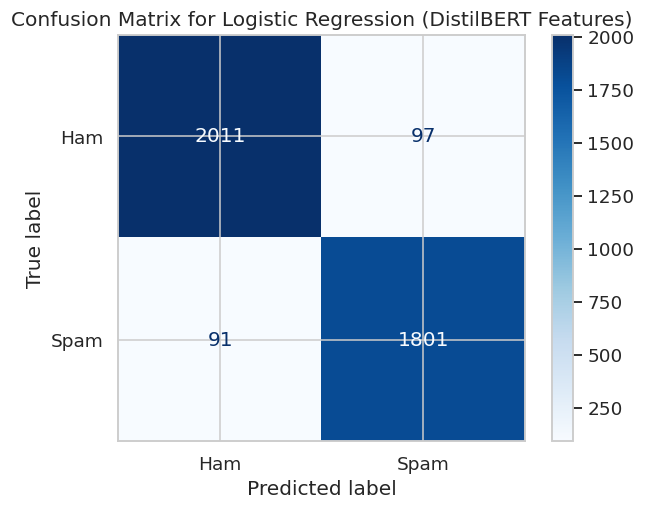

[LightGBM] [Info] Number of positive: 7568, number of negative: 8432
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473000 -> initscore=-0.108105
[LightGBM] [Info] Start training from score -0.108105


In [ ]:
!pip install -q transformers torch

import torch
from transformers import AutoTokenizer, AutoModel

# Define where to save our progress.
DRIVE_PATH = '/content/drive/My Drive/Spam_Project_Checkpoints/'
os.makedirs(DRIVE_PATH, exist_ok=True)
EMBEDDING_FILE = os.path.join(DRIVE_PATH, 'bert_embeddings.npy')
PROGRESS_FILE = os.path.join(DRIVE_PATH, 'progress.txt')


# Setup GPU Device & Load Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_NAME = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME).to(device)

# Prepare Data Sample (20 K to save time)
df_sample, _ = train_test_split(df, train_size=20000, stratify=df["label"], random_state=42)
sample_texts = df_sample['text'].tolist()
sample_labels = df_sample['label'].tolist()


# Define Helper Functions (with Save/Resume Logic)

def get_transformer_embeddings_with_resume(texts, batch_size=32):
    """
    Generates DistilBERT embeddings with save/resume functionality.
    Checks for existing progress and resumes, saving after each batch.
    """
    all_embeddings = []
    start_index = 0

    # Resume Logic
    if os.path.exists(EMBEDDING_FILE) and os.path.exists(PROGRESS_FILE):
        print("Found existing progress files. Attempting to resume...")
        all_embeddings = list(np.load(EMBEDDING_FILE))
        with open(PROGRESS_FILE, 'r') as f:
            completed_batches = int(f.read())
        start_index = completed_batches * batch_size
        print(f"Resuming from text index {start_index}...")
    else:
        print("No progress found. Starting from scratch.")

    model.eval()

    # Loop through texts in batches, starting from where we left off
    for i in tqdm(range(start_index, len(texts), batch_size), desc="Generating Embeddings"):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', truncation=True, padding=True, max_length=512).to(device)

        with torch.no_grad():
            outputs = model(**inputs)

        cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        all_embeddings.extend(list(cls_embeddings))

        # --- SAVE LOGIC ---
        # Save progress after every batch
        np.save(EMBEDDING_FILE, np.array(all_embeddings))
        with open(PROGRESS_FILE, 'w') as f:
            # Save the number of batches completed
            f.write(str((i // batch_size) + 1))

    return np.array(all_embeddings)

# Using helper functions from before
def evaluate_model_v2(model, model_name, X_test, y_test):
    """Calculates and displays evaluation metrics for a given fitted model."""
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n--- Evaluation for: {model_name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

def run_classification_experiment(X_features, y_labels, model_name):
    """Modified experiment runner for pre-computed features."""
    X_train, X_test, y_train, y_test = train_test_split(
        X_features, y_labels, test_size=0.2, random_state=42, stratify=np.array(y_labels)
    )
    logreg = LogisticRegression(solver='liblinear', random_state=42, C=10, penalty='l1')
    logreg.fit(X_train, y_train)
    evaluate_model_v2(logreg, f"Logistic Regression ({model_name})", X_test, y_test)

    lgbm = lgb.LGBMClassifier(random_state=42, learning_rate=0.1, n_estimators=200, num_leaves=40)
    lgbm.fit(X_train, y_train)
    evaluate_model_v2(lgbm, f"LightGBM ({model_name})", X_test, y_test)

# Run classifiers on new features
X_features_bert = get_transformer_embeddings_with_resume(sample_texts)
run_classification_experiment(X_features_bert, sample_labels, "DistilBERT Features")


Step 4: Preparing final data split for the model...
Training data shape: (16000, 768)
Testing data shape:  (4000, 768)

Step 5: Training and evaluating the LightGBM model...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 7568, number of negative: 8432
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473000 -> initscore=-0.108105
[LightGBM] [Info] Start training from score -0.108105

--- Evaluation for: LightGBM on DistilBERT Features ---
Accuracy: 0.9590

Classification Report:
              precision    recall  f1-score   support

         Ham       0.96      0.96      0.96      2108
        Spam       0.96      0.96      0.96      1892

    accuracy                           0.96      4000
   macro avg       0.96      0.96      0.96      4000
weighted avg       0.96      0.96      0.96      4000


Advanced Metrics:
Matthews Corr. Coef. (MCC): 0.9178
ROC AUC Score:            

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


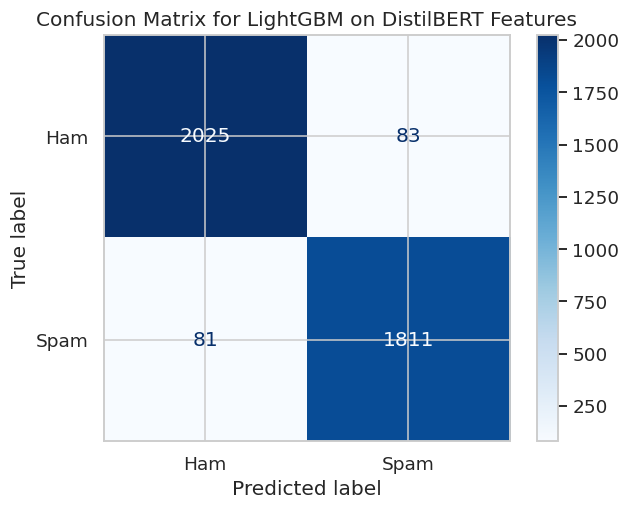

In [12]:
# Load features
X_features = np.load(EMBEDDING_FILE)

# Recreate Original Sample to Get Labels
# Ensures labels align perfectly with pre-computed embeddings.
df_sample, _ = train_test_split(df, train_size=20000, stratify=df["label"], random_state=42)
y_labels = df_sample['label'].tolist()

# Define Upgraded Helper Function for Evaluation
def evaluate_model_v2(model, model_name, X_test, y_test):
    """
    Calculates and displays a comprehensive set of evaluation metrics
    for a given fitted model.
    """
    print(f"\n--- Evaluation for: {model_name} ---")

    # --- Standard Predictions & Metrics ---
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

    # --- Advanced Metrics (Requires Probability Predictions) ---
    # Ensure model supports predict_proba before calculating
    if hasattr(model, "predict_proba"):
        # Get probabilities for the positive class (Spam)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Calculate advanced metrics
        mcc = matthews_corrcoef(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        logloss = log_loss(y_test, y_pred_proba)

        print("\nAdvanced Metrics:")
        print(f"Matthews Corr. Coef. (MCC): {mcc:.4f}")
        print(f"ROC AUC Score:              {roc_auc:.4f}")
        print(f"Log Loss:                   {logloss:.4f}")

    # Confusion Matrix Visualization
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()


# Split Data & Run LightGBM Classifier
# Ensure labels are a numpy array for stratify
y_labels = np.array(y_labels)

# Use same train/test split parameters for consistency
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_labels, test_size=0.2, random_state=42, stratify=y_labels
)
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape:  {X_test.shape}")

# Initialize the LightGBM model
lgbm = lgb.LGBMClassifier(
    random_state=42,
    learning_rate=0.1,
    n_estimators=200,
    num_leaves=40
)

# Train model
lgbm.fit(X_train, y_train)

# Evaluate final model using new function
evaluate_model_v2(lgbm, "LightGBM on DistilBERT Features", X_test, y_test)